In [1]:
! pip install stemming

  Using cached stemming-1.0.1-py3-none-any.whl


In [2]:
! pip install text2emotion

  Using cached text2emotion-0.0.5-py3-none-any.whl (57 kB)
  Using cached emoji-2.2.0-py3-none-any.whl


In [3]:
# ! pip install NRCLex

In [4]:
# ! pip install Cython

In [5]:
# ! pip uninstall pomegranate --yes
# ! pip install pomegranate --no-cache-dir

In [6]:
# ! pip uninstall numpy --yes
# ! pip install numpy==1.20.0

In [7]:
import pandas as pd
import numpy as np
from pandas import read_excel
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn import preprocessing

from stemming.porter2 import stem

# from nrclex import NRCLex

import seaborn as sns
import matplotlib.pyplot as plt
import text2emotion as te

import json
import re

from string import ascii_lowercase
import string
from nltk.data import load
import nltk
from collections import Counter
import scipy
from scipy import sparse
# For splitting comment into sentences:
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# from pomegranate import BayesianNetwork

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression

import time

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Dataset preparation

In [8]:
f_control = open('control_with_contribs.json')
control_users = json.load(f_control).keys()

f_sock = open('socks_with_contribs.json')
sock_users = json.load(f_sock).keys()

In [9]:
def describe_sets(y_train, y_test, set_nr):
    print("Describing dataset: " + str(set_nr))
    train_socks = 0
    train_control = 0
    for y in y_train:
        if y == 'sock':
            train_socks += 1
        else:
            train_control += 1
            
    print("Socks in training set: " + str(train_socks))
    print("Control in training set: " + str(train_control))
    
    
    test_socks = 0
    test_control = 0
    for y in y_test:
        if y == 'sock':
            test_socks += 1
        else:
            test_control += 1
            
    print("Socks in testing set: " + str(test_socks))
    print("Control in testing set: " + str(test_control))
    print("------------------------------------------")

In [10]:
X = list(sock_users) + list(control_users)
if not len(X) == len(sock_users) + len(control_users):
    print("ERROR")
y = ['sock'] * len(sock_users) + ['control'] * len(control_users)
if not len(y) == len(sock_users) + len(control_users):
    print('ERROR')

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0)
describe_sets(y_train1, y_test1, 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=11)
describe_sets(y_train2, y_test2, 2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=33)
describe_sets(y_train3, y_test3, 3)

Describing dataset: 1
Socks in training set: 1756
Control in training set: 1720
Socks in testing set: 727
Control in testing set: 763
------------------------------------------
Describing dataset: 2
Socks in training set: 1721
Control in training set: 1755
Socks in testing set: 762
Control in testing set: 728
------------------------------------------
Describing dataset: 3
Socks in training set: 1736
Control in training set: 1740
Socks in testing set: 747
Control in testing set: 743
------------------------------------------


# Text classifier

Load data -> Load matrices from files -> Create train and test sets -> Remove redundant features -> Run models

### Load data

In [11]:
f_control = open('control_with_contribs_MODIFIED_FORMAT.json')
control_contributions = json.load(f_control)

In [12]:
f_sock = open('socks_with_contribs_MODIFIED_FORMAT.json')
sock_contributions = json.load(f_sock)

In [13]:
# sock_contributions

## START HERE to create features

#### Create sparse matrices

In [36]:
sock_matrix_size = (len(sock_contributions), 240 + 1) # 240 features + 1 for storing revid
X_sock_contribs = scipy.sparse.dok_matrix(sock_matrix_size)

In [37]:
control_matrix_size = (len(control_contributions), 240 + 1) # 240 features + 1 for storing revid
X_control_contribs = scipy.sparse.dok_matrix(control_matrix_size)

#### Features List:

#### Adding sentence features:

In [38]:
# adds Total number of sentences, Sentence count without capital letter at the beginning, Question frequency, Sentence with small letter frequency
def add_sentence_features(contrib_list, matrix):
    for contrib in contrib_list:
        comments = contrib["comments"].replace("<signature>", "").replace("<auto-signature>", "")
        sentence_list = tokenizer.tokenize(comments)
        
        sentence_count = len(sentence_list)
        without_capital_letter_count = 0
        question_count = 0
        small_letter_count = 0
        
        for s in sentence_list:
            # some cleaning and removing special cases of section titles and discussion level markers:
            sentence = s
            sentence = sentence.rstrip()
            sentence = sentence.lstrip()
            
            if sentence.startswith("="):
                try:
                    part1, part2, part3 = sentence.split("= ", 3)
                    sentence = part3
                except:
                    sentence = part2
            elif sentence.startswith(":"):
                count = 0
                for ch in sentence:
                    if ch == ":" or ch == " ":
                        count += 1
                    else:
                        sentence = sentence[count:]
                        break
            
            # analyze the beginning of a sentence
            if len(sentence) > 0 and sentence[0].isalpha() and sentence[0].islower():
                small_letter_count += 1
            elif len(sentence) > 0 and not (sentence[0].isalpha() and sentence[0].isupper()):
                without_capital_letter_count += 1
                
            # analyze the end of the sentence:
            if len(sentence) > 0 and sentence[-1] == "?":
                question_count += 1
                

        matrix[contrib["nr_in_matrix"], 1] = sentence_count
        matrix[contrib["nr_in_matrix"], 2] = without_capital_letter_count
        sentence_count_or_1 = sentence_count if sentence_count > 0 else 1
        matrix[contrib["nr_in_matrix"], 3] = question_count/sentence_count_or_1
        matrix[contrib["nr_in_matrix"], 4] = small_letter_count/sentence_count_or_1    
        
#         true_sentences = []
#         for sentence in sentence_list:
#             if sentence == "<signature>" or sentence == "<auto-signature>":
#                 continue
#             else:
#                 true_sentences.append(sentence)
                
#         print(true_sentences)
        
        

In [39]:
add_sentence_features(sock_contributions, X_sock_contribs)

KeyError: 'nr_in_matrix'

In [ ]:
add_sentence_features(control_contributions, X_control_contribs)

#### Adding token features:

In [ ]:
def does_word_have_vowels(word):
    vowels = ['a', 'e', 'i', 'o', 'u', 'y']
    for l in word:
        if l in vowels:
            return True
        
    return False


# Adds:
#     Total number of tokens T 
#     Words without vowels T
#     Total contraction count T
#     All caps letter word count T
#     Function words frequency T
#     Small “i” frequency T
#     “he” frequency T
#     “she” frequency T
#     "A" error frequency T
#     "An" error frequency T
def add_token_features(contrib_list, function_words_filename, matrix):
    function_words = open(function_words_filename, 'r').read().replace('\n', ' ').split()

    for contrib in contrib_list:
        
        if contrib["comments"] != "":
            tokens = contrib["comments"].split(" ")
        else:
            tokens = []
            
        number_of_tokens = len(tokens)
        matrix[contrib["nr_in_matrix"], 5] = number_of_tokens
        matrix[contrib["nr_in_matrix"], 6] = len([word for word in tokens if not does_word_have_vowels(word)])
        matrix[contrib["nr_in_matrix"], 7] = len([word for word in tokens if "'" in word])
        matrix[contrib["nr_in_matrix"], 8] = len([word for word in tokens if word != "I" and word.isupper()])
        nr = 9
        number_of_tokens_or_1 = number_of_tokens if number_of_tokens > 0 else 1
        for fw in function_words:
            matrix[contrib["nr_in_matrix"], nr] = len([word for word in tokens if word.lower() == fw]) / number_of_tokens_or_1
            nr += 1
        matrix[contrib["nr_in_matrix"], 159] = len([word for word in tokens if word == "i"])/number_of_tokens_or_1
        matrix[contrib["nr_in_matrix"], 160] = len([word for word in tokens if word == "I"])/number_of_tokens_or_1
        matrix[contrib["nr_in_matrix"], 161] = len([word for word in tokens if word.lower() == "he"])/number_of_tokens_or_1
        matrix[contrib["nr_in_matrix"], 162] = len([word for word in tokens if word.lower() == "she"])/number_of_tokens_or_1   

        
        a_error = 0
        an_error = 0
        vowels = ['a', 'e', 'i', 'o', 'u', 'y']
        for count, token in enumerate(tokens):
            if token.lower() == "a" and (count + 1) < len(tokens) and len(tokens[count+1]) > 0 and tokens[count+1][0].lower() in vowels:
                a_error += 1
            elif token.lower() == "an" and (count + 1) < len(tokens) and len(tokens[count+1]) > 0 and tokens[count+1][0].isalpha() and tokens[count+1][0].lower() not in vowels:
                an_error += 1

        matrix[contrib["nr_in_matrix"], 163] = a_error/number_of_tokens_or_1  
        matrix[contrib["nr_in_matrix"], 164] = an_error/number_of_tokens_or_1   

            

            

In [ ]:
add_token_features(sock_contributions, "function_words.txt", X_sock_contribs)

In [ ]:
# sock_contributions

In [ ]:
add_token_features(control_contributions, "function_words.txt", X_control_contribs)

In [ ]:
# control_contributions

#### Adding character features:

In [ ]:
# Adds:
#     Total number of characters C
#     Total alphabet count C
#     Total punctuation count C
#     Two/three continuous punctuation count C 
#     Parenthesis count C
#     Emoticons count C
#     Happy emoticons count C
#     Quotation count C
#     Frequency of letters C
#     Full stop without white space frequency C
#     Digit frequency C
#     Uppercase frequency C
#     White space frequency C
#     Tab frequency C
#     Alpha frequency C

def add_character_features(contrib_list, matrix):
    for contrib in contrib_list:
        comment = contrib["comments"]
        comment_length = len(comment)
        
        matrix[contrib["nr_in_matrix"], 165] = comment_length
        matrix[contrib["nr_in_matrix"], 166] = len([ch for ch in comment if ch.isalpha()])
        matrix[contrib["nr_in_matrix"], 167] = len([ch for ch in comment if ch in string.punctuation])
        matrix[contrib["nr_in_matrix"], 168] = len(re.findall(r'[.!?]{2,3}', comment))
        matrix[contrib["nr_in_matrix"], 169] = len([ch for ch in comment if ch == '(' or ch == ')'])
        matrix[contrib["nr_in_matrix"], 170] = comment.count(":)") + comment.count(":-)") + comment.count(":(") + comment.count(";)") + comment.count(":D ") + comment.count("<3 ") + comment.count(":o ") + comment.count(":O ") + comment.count(":P ")
        matrix[contrib["nr_in_matrix"], 171] = comment.count(":)") + comment.count(":-)")
        matrix[contrib["nr_in_matrix"], 172] = len([ch for ch in comment if ch == '"'])
        non_whitespace_chars = len([ch for ch in comment if ch != ' '])
        nr = 173
        for letter in ascii_lowercase:
            if non_whitespace_chars != 0:
                matrix[contrib["nr_in_matrix"], nr] = len([ch for ch in comment if ch.lower() == letter]) / non_whitespace_chars
            else:
                matrix[contrib["nr_in_matrix"], nr] = 0
            nr += 1
        comment_length_or_1 = comment_length if comment_length > 0 else 1
        matrix[contrib["nr_in_matrix"], 199] = len(re.findall("\.(?![^\S])", comment)) / comment_length_or_1
        matrix[contrib["nr_in_matrix"], 200] = len([ch for ch in comment if ch.isdigit()]) / comment_length_or_1
        matrix[contrib["nr_in_matrix"], 201]= len([ch for ch in comment if ch.isupper()]) / comment_length_or_1
        matrix[contrib["nr_in_matrix"], 202] = len([ch for ch in comment if ch == " "]) / comment_length_or_1
        matrix[contrib["nr_in_matrix"], 203] = len([ch for ch in comment if ch == "\t"]) / comment_length_or_1
        matrix[contrib["nr_in_matrix"], 204] = len([ch for ch in comment if ch.isalpha()]) / comment_length_or_1

In [ ]:
add_character_features(sock_contributions, X_sock_contribs)

In [ ]:
add_character_features(control_contributions, X_control_contribs)

#### Part of Speech tagging

In [ ]:
# text = sock_contributions[10]["comments"]
# tokens = nltk.wordpunct_tokenize(text)
# print(tokens)

# tag = nltk.pos_tag(tokens)
# print(tag)

# text = re.sub(r'[^\w\s]', '', text)
# text

In [ ]:
# import nltk
# nltk.download('averaged_perceptron_tagger')

In [23]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
keys = tagdict.keys()
tag_labels = []
count = 0
for k in keys:
    if k[0].isalpha():
        tag_labels.append(k)
        count += 1
        
print(count)
print(sorted(tag_labels))



36
['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [ ]:
def complete_part_of_speech_tagging(contrib_list, matrix):
    for contrib in contrib_list:
        text = contrib["comments"]
        tokens = nltk.wordpunct_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter(tag for word, tag in tags)
        nr = 205
        total = sum(counts.values())
        for label in tag_labels:
            if label in counts:
                matrix[contrib["nr_in_matrix"], nr] = counts[label]/total
            else:
                matrix[contrib["nr_in_matrix"], nr] = 0
            nr += 1
            
#         for label in tag_labels:
#             name = str(label) + "_count"
#             if label in counts:
#                 contrib[name] = counts[label]
#             else:
#                 contrib[name] = 0
                   

In [ ]:
complete_part_of_speech_tagging(sock_contributions, X_sock_contribs)  
# sock_contributions

In [ ]:
complete_part_of_speech_tagging(control_contributions, X_control_contribs)
# control_contributions

### Save to files

In [ ]:
sparse.save_npz("sock_sparse_matrix.npz", X_sock_contribs.tocoo())

In [ ]:
sparse.save_npz("control_sparse_matrix.npz", X_control_contribs.tocoo())

### Convert to dataframes

In [ ]:
pd.DataFrame.sparse.from_spmatrix(X_sock_contribs)

In [ ]:
pd.DataFrame.sparse.from_spmatrix(X_control_contribs)

In [ ]:
# initial solution where everything was saved to json:
# dataframe_sock_contributions = pd.DataFrame(sock_contributions)
# dataframe_control_contributions = pd.DataFrame(control_contributions)

## START HERE for choosing best SVM

### Data preparation and normalization

In [14]:
X_sock_contribs = sparse.load_npz("sock_sparse_matrix.npz").tocsr().toarray()
X_control_contribs = sparse.load_npz("control_sparse_matrix.npz").tocsr().toarray()
# try to convert to csr matrix

In [15]:
count = 0
for contrib in sock_contributions:
    X_sock_contribs[count, 0] = contrib["revid"]
    contrib["nr_in_matrix"] = count
    count += 1
    
count = 0
for contrib in control_contributions:
    X_control_contribs[count, 0] = contrib["revid"]
    contrib["nr_in_matrix"] = count
    count += 1

#### First solution - classification per user:

In [ ]:
# SWM gives an error here - ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3474,) + inhomogeneous part.

In [ ]:
# def get_user_to_contrib_features(contributions_list, feature_matrix, skip_3_users):
#     users = set()
#     user2features = {}
#     for contrib in contributions_list:
#         user = contrib["author"]
#         if skip_3_users and user in ["Olgapelaez", "Lsanchezs01", "Ianisveria"]:
#             continue
#         row_nr = contrib["nr_in_matrix"]
#         if user not in users:
#             users.add(user)
#             user2features[user] = [feature_matrix[row_nr][1:]]
#         else:
#             user2features[user].append(feature_matrix[row_nr][1:])
            
#     return user2features

In [ ]:
# sock2features = get_user_to_contrib_features(sock_contributions, X_sock_contribs, False)

In [ ]:
# sock2features

In [ ]:
# control2features = get_user_to_contrib_features(control_contributions, X_control_contribs, True)

In [ ]:
# X = sock2features | control2features #merging 2 dictionaries
# X = list(X.values())

In [ ]:
# len(X) == len(sock2features) + len(control2features)

In [ ]:
# y = ["sock"] * len(sock2features) + ["control"] * len(control2features)

In [ ]:
# len(y) == len(X)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# sock = 0
# control = 0
# for y in y_train:
#     if y == 'sock':
#         sock += 1
#     elif y == "control":
#         control += 1
        
# print(sock)
# print(control)

#### Second solution - classification per comment:

In [16]:
def get_user_to_contrib_features(contributions_list, feature_matrix):
    users = set()
    user2features = {}
    for contrib in contributions_list:
        user = contrib["author"]
        row_nr = contrib["nr_in_matrix"]
        if user not in users:
            users.add(user)
            user2features[user] = [feature_matrix[row_nr][1:]]
        else:
            user2features[user].append(feature_matrix[row_nr][1:])
            
    return users, user2features

In [17]:
def split_and_scale_data(X_train_users, X_test_users):
    socks, sock2features = get_user_to_contrib_features(sock_contributions, X_sock_contribs)
    control, control2features = get_user_to_contrib_features(control_contributions, X_control_contribs)
    
    X_train = []
    y_train = []
    for user in X_train_users:
        if user in socks:
            features_list = sock2features[user]
            for feature in features_list:
                X_train.append(feature)
                y_train.append("sock")

        elif user in control:
            features_list = control2features[user]
            for feature in features_list:
                X_train.append(feature)
                y_train.append("control")
                
    control_count = 0
    sock_count = 0
    for y in y_train:
        if y == "sock":
            sock_count += 1
        else:
            control_count += 1

    print("Sock user comments count in training set: ")
    print(sock_count)
    print("Control user comments count in training set: ")
    print(control_count)
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    
    X_test = []
    y_test = []
    for user in X_test_users:
        if user in socks:
            features_list = sock2features[user]
            for feature in features_list:
                X_test.append(feature)
                y_test.append("sock")

        elif user in control:
            features_list = control2features[user]
            for feature in features_list:
                X_test.append(feature)
                y_test.append("control")
                
    
    control_count = 0
    sock_count = 0
    for y in y_test:
        if y == "sock":
            sock_count += 1
        else:
            control_count += 1

    print("Sock user comments count in test set: ")
    print(sock_count)
    print("Control user comments count in test set: ")
    print(control_count)
    
    scaler = preprocessing.StandardScaler().fit(X_test)
    X_test_scaled = scaler.transform(X_test)
    
    return socks, sock2features, control, control2features, X_train, X_train_scaled, y_train, X_test, X_test_scaled, y_test
    


In [18]:
def my_refit_criteria(cv_results_):
    return np.argmax(
        cv_results_['mean_test_f1'])

### SVM model - choosing the best manually

In [ ]:
all_metrics_linear = {}

In [ ]:
def individual_class_scorer(clf, X, y):
    y_pred = clf.predict(X)
    individual_scores = precision_recall_fscore_support(y, y_pred, labels = ["sock", "control"])
    return {'precision_socks': individual_scores[0][0], "recall_socks": individual_scores[1][0], "fscore_socks" : individual_scores[2][0],
            "support_socks": individual_scores[3][0],
           'precision_control': individual_scores[0][1], "recall_control": individual_scores[1][1], "fscore_control" : individual_scores[2][1],
           "support_control": individual_scores[3][1]}
    

In [ ]:
# Cs = [0.01, 0.1, 1, 10, 100, 1000]
# for c in Cs:
#     SVM = LinearSVC(C=c, max_iter=1000)
#     scores = cross_validate(SVM, X_train_scaled, y_train, cv=3, scoring=individual_class_scorer)
#     print(scores)
#     all_metrics_linear[c] = {'precision_socks': sum(scores['test_precision_socks'])/len(scores['test_precision_socks']),
#                              'recall_socks': sum(scores['test_recall_socks'])/len(scores['test_recall_socks']),
#                              'fscore_socks': sum(scores['test_fscore_socks'])/len(scores['test_fscore_socks']),
#                              'support_socks': sum(scores['test_support_socks'])/len(scores['test_support_socks']),
#                              'precision_control': sum(scores['test_precision_control'])/len(scores['test_precision_control']),
#                              'recall_control': sum(scores['test_recall_control'])/len(scores['test_recall_control']),
#                              'fscore_control': sum(scores['test_fscore_control'])/len(scores['test_fscore_control']),
#                              'support_control': sum(scores['test_support_control'])/len(scores['test_support_control'])}
    

In [ ]:
# all_metrics_linear

In [ ]:
# all_metrics_non_linear = {}

In [ ]:
# Cs = [0.01, 0.1, 1, 10, 100, 1000]
# for c in Cs:
#     SVM = svm.SVC(C=c, max_iter=1000)
#     scores = cross_validate(SVM, X_train_scaled, y_train, cv=3, scoring=individual_class_scorer)
#     all_metrics_non_linear[c] = {'precision_socks': sum(scores['test_precision_socks'])/len(scores['test_precision_socks']),
#                              'recall_socks': sum(scores['test_recall_socks'])/len(scores['test_recall_socks']),
#                              'fscore_socks': sum(scores['test_fscore_socks'])/len(scores['test_fscore_socks']),
#                              'support_socks': sum(scores['test_support_socks'])/len(scores['test_support_socks']),
#                              'precision_control': sum(scores['test_precision_control'])/len(scores['test_precision_control']),
#                              'recall_control': sum(scores['test_recall_control'])/len(scores['test_recall_control']),
#                              'fscore_control': sum(scores['test_fscore_control'])/len(scores['test_fscore_control']),
#                              'support_control': sum(scores['test_support_control'])/len(scores['test_support_control'])}
    

In [ ]:
# all_metrics_non_linear

In [ ]:
# all_metrics_non_linear_socks = {}
# all_metrics_non_linear_control = {}
# for key, items in all_metrics_non_linear.items():
#     data_socks = {}
#     data_control = {}
#     for k, it in items.items(): 
#         if k[-5:] == "socks":
#             data_socks[k[0:-6]] = it
#         elif k[-7:] == "control":
#             data_control[k[0:-8]] = it
#     data_socks.pop("support")
#     data_control.pop("support")
#     all_metrics_non_linear_socks[key] = data_socks
#     all_metrics_non_linear_control[key] = data_control
    
# all_metrics_non_linear_socks

In [ ]:
# all_metrics_linear_socks = {}
# all_metrics_linear_control = {}
# for key, items in all_metrics_linear.items():
#     data_socks = {}
#     data_control = {}
#     for k, it in items.items(): 
#         if k[-5:] == "socks":
#             data_socks[k[0:-6]] = it
#         elif k[-7:] == "control":
#             data_control[k[0:-8]] = it
#     data_socks.pop("support")
#     data_control.pop("support")
#     all_metrics_linear_socks[key] = data_socks
#     all_metrics_linear_control[key] = data_control
    
# all_metrics_linear_socks

In [ ]:
all_metrics_linear_control = {10: {'precision': 0.7439703098416555,
  'recall': 0.8161995036817054,
  'fscore': 0.7783332373218578},
 0.01: {'precision': 0.7403616192445192,
  'recall': 0.9604979455677148,
  'fscore': 0.8361442225269401},
 0.1: {'precision': 0.7408675224715799,
  'recall': 0.9587486269883243,
  'fscore': 0.8358043019326429},
 1: {'precision': 0.743934033117001,
  'recall': 0.9420419565246871,
  'fscore': 0.8313354787637631},
 100: {'precision': 0.7544373585601857,
  'recall': 0.7161222082095927,
  'fscore': 0.731427182322479},
 1000: {'precision': 0.7478099564037262,
  'recall': 0.781267374530464,
  'fscore': 0.7637313798006874}}

In [ ]:
all_metrics_linear_socks = {10: {'precision': 0.34281847127176146,
  'recall': 0.25413279388453347,
  'fscore': 0.29141152111839835},
 0.01: {'precision': 0.5051513834265998,
  'recall': 0.10546311083442922,
  'fscore': 0.17316348432289005},
 0.1: {'precision': 0.504044298826527,
  'recall': 0.109459724374951,
  'fscore': 0.17859579346486945},
 1: {'precision': 0.47728308009943254,
  'recall': 0.13905623950857102,
  'fscore': 0.2150369283026424},
 100: {'precision': 0.3402646672110248,
  'recall': 0.3788229123758433,
  'fscore': 0.34871083078620324},
 1000: {'precision': 0.34412379779849145,
  'recall': 0.3008310242864522,
  'fscore': 0.3193353902979337}}

In [ ]:
all_metrics_linear_control_df = pd.DataFrame.from_dict(all_metrics_linear_control, orient='index')
all_metrics_linear_control_df["class"] = "control"
all_metrics_linear_control_df

In [ ]:
all_metrics_linear_socks_df = pd.DataFrame.from_dict(all_metrics_linear_socks, orient='index')
all_metrics_linear_socks_df["class"] = "sock"
all_metrics_linear_socks_df

In [ ]:
all_metrics_linear_df = all_metrics_linear_socks_df.append(all_metrics_linear_control_df)
all_metrics_linear_df["C"] = [10.00, 0.01, 0.1, 1, 100, 1000, 10.00, 0.01, 0.1, 1, 100, 1000]
all_metrics_linear_df

In [ ]:
all_metrics_non_linear_control = {0.01: {'precision': 0.6949171084442692,
  'recall': 0.5039393569559144,
  'fscore': 0.5840787199568226},
 0.1: {'precision': 0.6800114963221399,
  'recall': 0.43453615936427864,
  'fscore': 0.5267263854018306},
 1: {'precision': 0.695659145177867,
  'recall': 0.49116526314362047,
  'fscore': 0.5742454015499711},
 10: {'precision': 0.711287878357365,
  'recall': 0.7037549326715755,
  'fscore': 0.7028387347322127},
 100: {'precision': 0.7260584155240216,
  'recall': 0.6986154618065443,
  'fscore': 0.7115498135077738},
 1000: {'precision': 0.7170864743811948,
  'recall': 0.638189387467285,
  'fscore': 0.6750133016719255}}

In [ ]:
all_metrics_non_linear_socks = {0.01: {'precision': 0.23834935368476953,
  'recall': 0.4124522209731552,
  'fscore': 0.30202656742385287},
 0.1: {'precision': 0.23508038772831275,
  'recall': 0.4620337174324975,
  'fscore': 0.3100121146650065},
 1: {'precision': 0.2409558908281786,
  'recall': 0.4301325427487262,
  'fscore': 0.3080377691720133},
 10: {'precision': 0.23780957707736441,
  'recall': 0.2483657755849524,
  'fscore': 0.23362875137080816},
 100: {'precision': 0.2722838486730301,
  'recall': 0.29993325889339423,
  'fscore': 0.2842939541003314},
 1000: {'precision': 0.25756236040918523,
  'recall': 0.3321941402697722,
  'fscore': 0.2896891105738957}}

In [ ]:
all_metrics_non_linear_control_df = pd.DataFrame.from_dict(all_metrics_non_linear_control, orient='index')
all_metrics_non_linear_control_df["class"] = "control"
all_metrics_non_linear_control_df

In [ ]:
all_metrics_non_linear_sock_df = pd.DataFrame.from_dict(all_metrics_non_linear_socks, orient='index')
all_metrics_non_linear_sock_df["class"] = "sock"
all_metrics_non_linear_sock_df

In [ ]:
all_metrics_non_linear_df = all_metrics_non_linear_sock_df.append(all_metrics_non_linear_control_df)
all_metrics_non_linear_df["C"] = [0.01, 0.1, 1, 10.00, 100, 1000, 0.01, 0.1, 1, 10.00, 100, 1000]
all_metrics_non_linear_df

In [ ]:
# # OLD RESULTS - MACROS:
# all_macros = {100: {'precision_macro': [0.55711291, 0.54100187, 0.5169613 ],
#                     'recall_macro': [0.5561155 , 0.54469261, 0.51938065],
#                     'f1_macro': [0.55656689, 0.54140883, 0.51431241]}, 
#               0.01: {'precision_macro': [0.6438183 , 0.64100571, 0.59882995],
#                      'recall_macro': [0.55554344, 0.54012983, 0.53045765],
#                      'f1_macro': [0.54326594, 0.51490797, 0.50316979]},
#               0.1: {'precision_macro': [0.6443881 , 0.64299848, 0.60082289],
#                     'recall_macro': [0.556121  , 0.5410002 , 0.53138228],
#                     'f1_macro': [0.54418575, 0.51631805, 0.50472967]},
#               1: {'precision_macro': [0.6374456 , 0.64789249, 0.61130852],
#                   'recall_macro': [0.55770628, 0.54856637, 0.53831141], 
#                   'f1_macro': [0.54798645, 0.53006615, 0.51698248]}, 
#               10: {'precision_macro': [0.59470996, 0.59282679, 0.59169265],
#                    'recall_macro': [0.55674629, 0.55234767, 0.56667402],
#                    'f1_macro': [0.55427791, 0.54763942, 0.56879747]},
#               1000: {'precision_macro': [0.54741115, 0.5643553 , 0.55352005],
#                      'recall_macro': [0.55641191, 0.57603562, 0.55775827],
#                      'f1_macro': [0.54281096, 0.56183426, 0.55450905]}}
# all_macros_non_linear = {0.01: {'precision_macro': [0.64380473, 0.64090119, 0.59872593], 
#                                 'recall_macro': [0.55560606, 0.54004732, 0.53043777],
#                                 'f1_macro': [0.54337735, 0.51476009, 0.50315226]},
#                          0.1: {'precision_macro': [0.64249014, 0.64303917, 0.60059449],
#                                'recall_macro': [0.55578586, 0.54120795, 0.53131119],
#                                'f1_macro': [0.54389249, 0.51672292, 0.50462977]},
#                          1: {'precision_macro': [0.63860373, 0.64210846, 0.61700708],
#                              'recall_macro': [0.55870484, 0.5450333 , 0.5434027 ],
#                              'f1_macro': [0.54949971, 0.52431718, 0.52585655]},
#                          10: {'precision_macro': [0.55607189, 0.60427197, 0.55945587],
#                               'recall_macro': [0.52874793, 0.55893326, 0.53919158],
#                               'f1_macro': [0.51559926, 0.55581829, 0.53531245]},
#                          100: {'precision_macro': [0.55649032, 0.57402902, 0.56033563],
#                                'recall_macro': [0.55606969, 0.57070702, 0.56588999],
#                                'f1_macro': [0.5562713 , 0.57204949, 0.56150965]},
#                          1000: {'precision_macro': [0.53347807, 0.55250657, 0.56162268],
#                                 'recall_macro': [0.53828302, 0.54942921, 0.57016863],
#                                 'f1_macro': [0.53175054, 0.55046919, 0.56177064]}}

In [ ]:
# all_scores_non_linear = {}

In [ ]:
# OLD ALGO:
# Cs = [0.01, 0.1, 1, 10, 100, 1000]
# for c in Cs:
#     SVM = LinearSVC(C=c, max_iter=2000)
#     scores = cross_validate(SVM, X_train_scaled, y_train, cv=3, scoring=['precision_macro', 'recall_macro', 'f1_macro'])
#     all_scores_non_linear[c] = {'precision_macro': scores['test_precision_macro'], 'recall_macro': scores['test_recall_macro'], 'f1_macro': scores['test_f1_macro']}
    

In [ ]:
# # OLD ALGO:
# all_scores_means = {}
# for c, metrics in all_scores.items():
#     res = {}
#     for metric, values in metrics.items():
#         res[metric] = sum(values)/len(values)
#     all_scores_means[c] = res
        
# all_scores_nonlinear_means = {}
# for c, metrics in all_scores_non_linear.items():
#     res = {}
#     for metric, values in metrics.items():
#         res[metric] = sum(values)/len(values)
#     all_scores_nonlinear_means[c] = res       

In [ ]:
# sns.lineplot(data=all_metrics_linear_socks)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(15,8))
fig.suptitle("Precision, recall and fscore with different C values on linear SVM", size = 15)
sns.barplot(ax = ax1, data=all_metrics_linear_df, x = "C", y = "precision", hue = "class")
sns.barplot(ax = ax2, data=all_metrics_linear_df, x = "C", y = "recall", hue = "class")
sns.barplot(ax = ax3, data=all_metrics_linear_df, x = "C", y = "fscore", hue = "class")
plt.savefig('metrics_on_linearSVM.png')

In [ ]:
# sns.lineplot(data=all_metrics_linear_socks)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(15,8))
ax1.set_ylim([0, 1])
fig.suptitle("Precision, recall and fscore with different C values on rbf-kernel SVM", size = 15)
sns.barplot(ax = ax1, data=all_metrics_non_linear_df, x = "C", y = "precision", hue = "class")
sns.barplot(ax = ax2, data=all_metrics_non_linear_df, x = "C", y = "recall", hue = "class")
sns.barplot(ax = ax3, data=all_metrics_non_linear_df, x = "C", y = "fscore", hue = "class")
plt.savefig('metrics_on_rbfkernelSVM.png')

In [ ]:
# sns.lineplot(data=all_scores_means)

In [ ]:
# SVM = svm.SVC(C = 1000, max_iter = 1000) # regularisation parameter (C), you can try different kernels
#SVM = LinearSVC(C=100, max_iter=2000)

In [ ]:
# scores = cross_validate(SVM, X_train_scaled, y_train, cv=3, scoring=['precision_macro', 'recall_macro', 'f1_macro'])
# SVM.fit(X_train_scaled, y_train) # here X_train cannot be dok matrix?

## 3 RUN LOOP

In [19]:
def get_test_metrics(model, scale):
    start = time.time()
    if scale:
        predicted = model.predict(X_test_scaled)
    else:
        predicted = model.predict(X_test)
    test_time = time.time() - start
    print("Confusion matrix for comments: ")
    print(confusion_matrix(y_test, predicted, labels = ["control", "sock"]))
    tn, fp, fn, tp = confusion_matrix(y_test, predicted, labels = ["control", "sock"]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (tn + fp)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    print(classification_report(y_test, predicted, target_names = ["control", "socks"]))
    
    user2contrib_nr = {}
    for user in X_test_users:
        if user in socks:
            user2contrib_nr[user] = len(sock2features[user])
        else:
            user2contrib_nr[user] = len(control2features[user])
    
    count = 0
    user_classification_predictions = []
    for user in X_test_users:
        contrib_nr = user2contrib_nr[user]
        contrib_predictions = predicted[count:(count+contrib_nr)]
        counts = Counter(label for label in contrib_predictions)
        if "control" not in counts and "sock" in counts:
            user_classification_predictions.append("sock")
        elif "sock" not in counts and "control" in counts:
            user_classification_predictions.append("control")
        elif counts["sock"] >= counts["control"]:
            user_classification_predictions.append("sock")
        elif counts["control"] > counts["sock"]:
            user_classification_predictions.append("control")
        else:
            print("ERROR")
        count += contrib_nr
        
    print("Confusion matrix for users:")
    print(confusion_matrix(y_test_users, user_classification_predictions, labels = ["control", "sock"]))
    tn, fp, fn, tp = confusion_matrix(y_test_users, user_classification_predictions, labels = ["control", "sock"]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (tn + fp)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    print(classification_report(y_test_users, user_classification_predictions, target_names = ["control", "socks"]))   
    class_report_dict = classification_report(y_test_users, user_classification_predictions, target_names = ["control", "socks"], output_dict = True )
    
    return tpr, fpr, class_report_dict, test_time

In [20]:
def fill_in_results(model, tpr, fpr, class_report_dict, test_time, train_time):
    archetype1_results[model]["TPR"].append(tpr)
    archetype1_results[model]["FPR"].append(fpr)
    archetype1_results[model]["Precision"].append(class_report_dict["macro avg"]["precision"])
    archetype1_results[model]["F-measure"].append(class_report_dict["macro avg"]["f1-score"])
    archetype1_results[model]["Train_time"].append(train_time)
    archetype1_results[model]["Test_time"].append(test_time)
    

In [23]:
archetype1_results = {"SVM" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "RF" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "NB" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "KNN" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "ADA" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []}}

for data in [(X_train1, X_test1, y_train1, y_test1), (X_train2, X_test2, y_train2, y_test2), (X_train3, X_test3, y_train3, y_test3)]:
    X_train_users = data[0]
    X_test_users = data[1]
    y_train_users = data[2] 
    y_test_users = data[3]
    socks, sock2features, control, control2features, X_train, X_train_scaled, y_train, X_test, X_test_scaled, y_test = split_and_scale_data(X_train_users, X_test_users)

    ### SVM model - choosing the best with GridSearchCV

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'max_iter':[1000,2000]
    }

    grid = GridSearchCV(svm.SVC(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_scaled, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_)

    #### The best SVM

    SVM = svm.SVC(C = grid.best_params_["C"], max_iter = grid.best_params_["max_iter"])                
    start = time.time()
    SVM.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_test_metrics(SVM, True)
    fill_in_results("SVM", tpr, fpr, class_report_dict, test_time, train_time) 
         
    
    #### Choosing the best RF

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'bootstrap': [True, False],
        'max_depth': [80, 100, 120, None],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'n_estimators': [50, 100]
    }

    grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    grid.fit(X_train, y_train) 

    print(grid.best_params_)
                      
    # The best RF
    best_RF_1 = RandomForestClassifier(bootstrap= grid.best_params_["bootstrap"], criterion= grid.best_params_["criterion"], max_depth= grid.best_params_["max_depth"], n_estimators= grid.best_params_["n_estimators"])
    start = time.time()
    best_RF_1.fit(X_train, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_test_metrics(best_RF_1, False)
    fill_in_results("RF", tpr, fpr, class_report_dict, test_time, train_time)
                      


    #### Choosing the best NB

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'var_smoothing': [10 ** -50, 10 ** -40, 10 ** -30, 10 ** -20, 10 ** -15, 10 ** -10, 10 ** -9, 10 ** -8, 10 ** -7, 10 ** -6, 10 ** -5]
    }

    grid = GridSearchCV(GaussianNB(), param_grid, scoring = scoring, cv = 5, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_)
    
    # The best NB:
    best_NB_1 = GaussianNB(var_smoothing= grid.best_params_["var_smoothing"])
    start = time.time()
    best_NB_1.fit(X_train, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_test_metrics(best_NB_1, False)
    fill_in_results("NB", tpr, fpr, class_report_dict, test_time, train_time)

    #### Choosing the best kNN

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'n_neighbors': [1,2,3,4,5,10,15,20],
        'weights':['uniform', 'distance']
    }

    grid = GridSearchCV(KNeighborsClassifier(n_jobs = -1), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_scaled, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_) 

    # The best KNN:
    best_kNN_1 = KNeighborsClassifier(n_neighbors= grid.best_params_["n_neighbors"], weights= grid.best_params_["weights"])
    start = time.time()
    best_kNN_1.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_test_metrics(best_kNN_1, True)
    fill_in_results("KNN", tpr, fpr, class_report_dict, test_time, train_time)

    #### Choosing the best BN

    #### Choosing the best ADA

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'n_estimators': list(range(1,50, 10)),
        'learning_rate': list(range(1,10,1)),
        'algorithm':['SAMME', 'SAMME.R']
    }

    grid = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_) 
    

    # The best ADA:
    best_ADA_1 = AdaBoostClassifier(algorithm= grid.best_params_["algorithm"], learning_rate= grid.best_params_["learning_rate"], n_estimators= grid.best_params_["n_estimators"])
    start = time.time()
    best_ADA_1.fit(X_train, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_test_metrics(best_ADA_1, False)
    fill_in_results("ADA", tpr, fpr, class_report_dict, test_time, train_time)

Sock user comments count in training set: 
29455
Control user comments count in training set: 
71926
Sock user comments count in test set: 
10642
Control user comments count in test set: 
34867
Choosing SVM


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Confusion matrix for comments: 
[[19200 15667]
 [ 6381  4261]]
TPR: 0.4003946626573952
FPR: 0.4493360484125391
              precision    recall  f1-score   support

     control       0.75      0.55      0.64     34867
       socks       0.21      0.40      0.28     10642

    accuracy                           0.52     45509
   macro avg       0.48      0.48      0.46     45509
weighted avg       0.63      0.52      0.55     45509

Confusion matrix for users:
[[558 205]
 [462 265]]
TPR: 0.36451169188445665
FPR: 0.2686762778505898
              precision    recall  f1-score   support

     control       0.55      0.73      0.63       763
       socks       0.56      0.36      0.44       727

    accuracy                           0.55      1490
   macro avg       0.56      0.55      0.53      1490
weighted avg       0.56      0.55      0.54      1490

Choosing RF
Confusion matrix for comments: 
[[33030  1837]
 [ 7853  2789]]
TPR: 0.2620747979703063
FPR: 0.05268592078469613
           

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Confusion matrix for comments: 
[[19388 13673]
 [ 8150  3869]]
TPR: 0.3219069806140278
FPR: 0.4135688575663168
              precision    recall  f1-score   support

     control       0.70      0.59      0.64     33061
       socks       0.22      0.32      0.26     12019

    accuracy                           0.52     45080
   macro avg       0.46      0.45      0.45     45080
weighted avg       0.58      0.52      0.54     45080

Confusion matrix for users:
[[547 181]
 [511 251]]
TPR: 0.3293963254593176
FPR: 0.24862637362637363
              precision    recall  f1-score   support

     control       0.52      0.75      0.61       728
       socks       0.58      0.33      0.42       762

    accuracy                           0.54      1490
   macro avg       0.55      0.54      0.52      1490
weighted avg       0.55      0.54      0.51      1490

Choosing RF
Confusion matrix for comments: 
[[31712  1349]
 [ 9165  2854]]
TPR: 0.2374573591812963
FPR: 0.04080336347962857
           

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Confusion matrix for comments: 
[[20359 12484]
 [ 8115  3605]]
TPR: 0.3075938566552901
FPR: 0.3801114392716865
              precision    recall  f1-score   support

     control       0.72      0.62      0.66     32843
       socks       0.22      0.31      0.26     11720

    accuracy                           0.54     44563
   macro avg       0.47      0.46      0.46     44563
weighted avg       0.59      0.54      0.56     44563

Confusion matrix for users:
[[603 140]
 [527 220]]
TPR: 0.29451137884872824
FPR: 0.18842530282637954
              precision    recall  f1-score   support

     control       0.53      0.81      0.64       743
       socks       0.61      0.29      0.40       747

    accuracy                           0.55      1490
   macro avg       0.57      0.55      0.52      1490
weighted avg       0.57      0.55      0.52      1490

Choosing RF
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END bootstrap=True, criterion=gini, max_depth=80, n_est

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=1, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=1, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=1, n_estimators=1; total time=   1.2s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=11; total time=   7.4s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=11; total time=   7.4s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=11; total time=   7.2s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=21; total time=  13.7s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=21; total time=  13.6s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=21; total time=  13.3s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=31; total time=  19.3s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=31; total time=  17.9s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=31; total time=  19.1s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=41; total time=  25.6s
[CV] END ..algorithm=SAMME, learning_rate=1, n_estimators=41; total time=  23.4s
[CV] END ..algorithm=SAMME, 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=2, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=2, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=2, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=11; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=11; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=11; total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=21; total time=  12.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=21; total time=  13.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=21; total time=  13.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=31; total time=  19.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=31; total time=  19.6s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=31; total time=  19.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=41; total time=  25.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=41; total time=  23.9s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=2, n_estimators=41; total time=  23.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=3, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=3, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=3, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=11; total time=   4.5s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=11; total time=   4.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=11; total time=   4.7s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=21; total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=21; total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=21; total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=31; total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=31; total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=31; total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=41; total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=41; total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 9, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=3, n_estimators=41; total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=4, n_estimators=1; total time=   1.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=4, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=4, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=11; total time=   3.5s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=11; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=11; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=21; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=21; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=21; total time=   3.9s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=31; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=31; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 7, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=31; total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=41; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=41; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=4, n_estimators=41; total time=   3.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=5, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=5, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=5, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=11; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=11; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=11; total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=21; total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=21; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=21; total time=   2.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=31; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=31; total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=31; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=41; total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=41; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=5, n_estimators=41; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=6, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=6, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=6, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=11; total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=11; total time=   2.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=11; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=21; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=21; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=21; total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=31; total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=31; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=31; total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=41; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=41; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=6, n_estimators=41; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=7, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=7, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=7, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=11; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=11; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=11; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=21; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=21; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=21; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=31; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=31; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=31; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=41; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=41; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=7, n_estimators=41; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=8, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=8, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=8, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=11; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=11; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=11; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=21; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=21; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=21; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=31; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=31; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=31; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=41; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=41; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=8, n_estimators=41; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=9, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=9, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ...algorithm=SAMME, learning_rate=9, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=11; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=11; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=11; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=21; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=21; total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=21; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=31; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=31; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=31; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=41; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=41; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..algorithm=SAMME, learning_rate=9, n_estimators=41; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=1, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=1, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=1, n_estimators=1; total time=   1.2s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; total time=   7.0s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; total time=   7.0s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; total time=   7.0s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; total time=  12.7s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; total time=  12.6s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; total time=  12.8s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=31; total time=  19.0s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=31; total time=  18.6s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=31; total time=  18.6s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=41; total time=  24.6s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=41; total time=  24.1s
[CV] END algorithm=SAMME.R, 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=2, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=2, n_estimators=1; total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=2, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=11; total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=11; total time=   7.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=11; total time=   7.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=21; total time=  12.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=21; total time=  12.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=21; total time=  12.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=31; total time=  18.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=31; total time=  18.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=31; total time=  18.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=41; total time=  24.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=41; total time=  25.6s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=2, n_estimators=41; total time=  25.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=3, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=3, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=3, n_estimators=1; total time=   1.2s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=11; total time=   4.7s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=11; total time=   4.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=11; total time=   4.8s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=21; total time=   6.1s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=21; total time=   6.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=21; total time=   6.0s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=31; total time=   7.4s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=31; total time=   7.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=31; total time=   7.4s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=41; total time=   8.6s
[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=41; total time=   8.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=3, n_estimators=41; total time=   8.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=4, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=4, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=4, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=11; total time=   3.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=11; total time=   3.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=11; total time=   3.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=21; total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=21; total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=21; total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=31; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=31; total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=31; total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=41; total time=   7.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=41; total time=   7.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=4, n_estimators=41; total time=   7.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=5, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=5, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=5, n_estimators=1; total time=   1.2s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=11; total time=   3.3s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=11; total time=   3.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=11; total time=   3.4s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=21; total time=   4.8s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=21; total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=21; total time=   4.7s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=31; total time=   6.2s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=31; total time=   6.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=31; total time=   6.3s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=41; total time=   7.5s
[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=41; total time=   7.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=5, n_estimators=41; total time=   7.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=6, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=6, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=6, n_estimators=1; total time=   1.2s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=11; total time=   3.4s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=11; total time=   3.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=11; total time=   3.4s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=21; total time=   4.6s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=21; total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=21; total time=   4.8s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=31; total time=   6.0s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=31; total time=   6.1s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=31; total time=   6.0s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=41; total time=   7.2s
[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=41; total time=   7.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=6, n_estimators=41; total time=   7.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=7, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=7, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=7, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=11; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=11; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=11; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=21; total time=   4.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=21; total time=   4.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=21; total time=   4.6s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=31; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=31; total time=   5.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=31; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=41; total time=   7.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=41; total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=7, n_estimators=41; total time=   7.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=8, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=8, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=8, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=11; total time=   2.9s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=11; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=11; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=21; total time=   4.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=21; total time=   4.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=21; total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=31; total time=   5.6s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=31; total time=   5.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=31; total time=   5.5s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=41; total time=   6.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=41; total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=8, n_estimators=41; total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=9, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=9, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .algorithm=SAMME.R, learning_rate=9, n_estimators=1; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=11; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=11; total time=   2.9s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=11; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=21; total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=21; total time=   4.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=21; total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=31; total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=31; total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=31; total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=41; total time=   6.7s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=41; total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=9, n_estimators=41; total time=   6.7s
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 41}
Confusion matrix for comments: 
[[31230  1613]
 [ 9514  2206]]
TPR: 0.18822525597269624
FPR: 0.049112444052004996
              precision    recall  f1-score   support

     control       0.77      0.95      0.85     32843
       socks       0.58      0.19      0.28     11720

    accuracy                           0.75     44563
   macro avg       0.67      0.57      0.57     44563
weighted avg       0.72      0.75      0.70     44563

Confusion matrix for users:
[[674  69]
 [599 148]]
TPR: 0.19812583668005354
FPR: 0.09286675639300135
              precision    recall  f1-score   support

     control       0.53      0.91      0.67       743
       socks       0.68      0.20      0.31       747

    accuracy                           0.55      1490
   macro avg       0.61      0.55      0.49      1490
weighted avg       0.61      0.55      0

In [24]:
archetype1_results

{'SVM': {'TPR': [0.36451169188445665, 0.3293963254593176, 0.29451137884872824],
  'FPR': [0.2686762778505898, 0.24862637362637363, 0.18842530282637954],
  'Precision': [0.5554443053817272, 0.5490158755163481, 0.572369714847591],
  'F-measure': [0.5343424929870011, 0.5164887520844237, 0.5206787269865936],
  'Train_time': [34.96856474876404, 60.0056095123291, 119.58577036857605],
  'Test_time': [9.926099061965942, 17.51729655265808, 39.23457860946655]},
 'RF': {'TPR': [0.2984869325997249, 0.22440944881889763, 0.19544846050870146],
  'FPR': [0.08256880733944955, 0.061813186813186816, 0.059219380888290714],
  'Precision': [0.6767561983471074, 0.6638867085295657, 0.6530566801619433],
  'F-measure': [0.5702812195020059, 0.5160054669257124, 0.4979603414527885],
  'Train_time': [71.8257942199707, 36.6587188243866, 75.61897850036621],
  'Test_time': [1.3748786449432373, 0.6814911365509033, 1.3325955867767334]},
 'NB': {'TPR': [0.405777166437414, 0.4146981627296588, 0.3132530120481928],
  'FPR':

In [26]:
import pickle

with open("archetype1_results.pickle", 'wb') as f:
    pickle.dump(archetype1_results, f)

In [25]:
for model, results in archetype1_results.items():
    print("--------------------------")
    print(str(model) + " RESULTS: ")
    iteration_dict = results.copy()
    for metric, res in iteration_dict.items():  
        print(metric)
        average = sum(res)/len(res)
        name = metric + " AVG"
        archetype1_results[model][name] = average
        print("M = " + str(average))
        std = np.std(res)
        name = metric + " STD"
        archetype1_results[model][name] = std
        print("STD = " + str(std))
        

--------------------------
SVM RESULTS: 
TPR
M = 0.32947313206416745
STD = 0.02857755973622081
FPR
M = 0.23524265143444767
STD = 0.034101786491493306
Precision
M = 0.5589432985818887
STD = 0.009849963381944113
F-measure
M = 0.5238366573526728
STD = 0.007623140612715353
Train_time
M = 71.51998154322307
STD = 35.491345838816926
Test_time
M = 22.225991408030193
STD = 12.419758418942004
--------------------------
RF RESULTS: 
TPR
M = 0.2394482806424413
STD = 0.04338860472271323
FPR
M = 0.06786712501364235
STD = 0.010449451491209802
Precision
M = 0.6645665290128722
STD = 0.009687222080981168
F-measure
M = 0.5280823426268356
STD = 0.03073505648254374
Train_time
M = 61.36783051490784
STD = 17.540471528197294
Test_time
M = 1.129655122756958
STD = 0.31736958807364596
--------------------------
NB RESULTS: 
TPR
M = 0.37790944707175517
STD = 0.04586383459894207
FPR
M = 0.29385483158310893
STD = 0.04368423970098256
Precision
M = 0.5476427397880548
STD = 0.006380138187107139
F-measure
M = 0.5282160

In [27]:
# save results to excel:
archetype1_results_df = pd.DataFrame(data=archetype1_results)
archetype1_results_df = archetype1_results_df.T
archetype1_results_df.to_excel('text_results.xlsx')
archetype1_results_df

,TPR,FPR,Precision,F-measure,Train_time,Test_time,TPR AVG,TPR STD,FPR AVG,FPR STD,Precision AVG,Precision STD,F-measure AVG,F-measure STD,Train_time AVG,Train_time STD,Test_time AVG,Test_time STD
SVM,"[0.36451169188445665, 0.3293963254593176, 0.29...","[0.2686762778505898, 0.24862637362637363, 0.18...","[0.5554443053817272, 0.5490158755163481, 0.572...","[0.5343424929870011, 0.5164887520844237, 0.520...","[34.96856474876404, 60.0056095123291, 119.5857...","[9.926099061965942, 17.51729655265808, 39.2345...",0.329473,0.028578,0.235243,0.034102,0.558943,0.00985,0.523837,0.007623,71.519982,35.491346,22.225991,12.419758
RF,"[0.2984869325997249, 0.22440944881889763, 0.19...","[0.08256880733944955, 0.061813186813186816, 0....","[0.6767561983471074, 0.6638867085295657, 0.653...","[0.5702812195020059, 0.5160054669257124, 0.497...","[71.8257942199707, 36.6587188243866, 75.618978...","[1.3748786449432373, 0.6814911365509033, 1.332...",0.239448,0.043389,0.067867,0.010449,0.664567,0.009687,0.528082,0.030735,61.367831,17.540472,1.129655,0.31737
NB,"[0.405777166437414, 0.4146981627296588, 0.3132...","[0.3053735255570118, 0.34065934065934067, 0.23...","[0.554823836073836, 0.5393211096303785, 0.5487...","[0.5423061377677695, 0.5285162711722211, 0.513...","[0.9221699237823486, 0.9146099090576172, 0.848...","[0.4073188304901123, 0.4120759963989258, 0.366...",0.377909,0.045864,0.293855,0.043684,0.547643,0.00638,0.528216,0.011629,0.895051,0.03315,0.395375,0.020347
KNN,"[0.2640990371389271, 0.4356955380577428, 0.456...","[0.18086500655307994, 0.22115384615384615, 0.2...","[0.5603056426332289, 0.6210670551207376, 0.629...","[0.506659168921156, 0.5932374848432358, 0.6062...","[0.06650161743164062, 0.06644868850708008, 0.0...","[78.41899299621582, 77.97243595123291, 76.1179...",0.385429,0.086212,0.208479,0.019548,0.603718,0.030903,0.568708,0.044195,0.064509,0.00278,77.503114,0.996306
ADA,"[0.3425034387895461, 0.26246719160104987, 0.19...","[0.17300131061598953, 0.1304945054945055, 0.09...","[0.6112621855541276, 0.6038366073328132, 0.605...","[0.5618018914499059, 0.5183879256778596, 0.487...","[38.68985557556152, 38.38551115989685, 35.5174...","[1.7351768016815186, 1.35416841506958, 1.62400...",0.267699,0.059058,0.132121,0.032735,0.606947,0.003149,0.522681,0.030342,37.53094,1.429161,1.571118,0.159979


# Non-text classifier

### Load data

In [22]:
f_control = open('control_with_contribs.json')
control_data = json.load(f_control)

f_control2 = open('control_registrations.json')
control2registration = json.load(f_control2)

In [23]:
f_sock = open('socks_with_contribs.json')
sock_data = json.load(f_sock)

f_sock2 = open('sock_registrations.json')
sock2registration = json.load(f_sock2)

## START HERE to create features

In [24]:
control2feature = []
sock2feature = []

In [25]:
f = open("control_first_contribs.json")
first_contrib_dict = json.load(f)

In [26]:
def getAverageIntervalBetweenRegistrationAndContrib(sock_data, sock_registrations, control_data, control_registrations, first_contrib_dict):
    date_format = "%Y-%m-%dT%H:%M:%S"
    interval_list = []
    #socks:
    for user, contribs in sock_data.items():
        first_contrib_timestamp = contribs[0]["timestamp"]
        for c in contribs:
            first_contrib_timestamp = min (first_contrib_timestamp, c["timestamp"])
            
        if sock_registrations[user] is not None and sock_registrations[user] != "invalid":
            timestamp_reg = datetime.strptime(sock_registrations[user][:-1], date_format)
            timestamp_contrib = datetime.strptime(first_contrib_timestamp[:-1], date_format)
            diff = timestamp_contrib - timestamp_reg
            interval_list.append(diff.total_seconds())
    
    # control:
    for user, contribs in control_data.items():
        if user in first_contrib_dict.keys():
            first_contrib_timestamp = first_contrib_dict[user]

            if control_registrations[user] is not None and control_registrations[user] != "invalid":
                timestamp_reg = datetime.strptime(control_registrations[user][:-1], date_format)
                timestamp_contrib = datetime.strptime(first_contrib_timestamp[:-1], date_format)
                diff = timestamp_contrib - timestamp_reg
                interval_list.append(diff.total_seconds())
                
    return int(sum(interval_list)/len(interval_list))


average_interval = getAverageIntervalBetweenRegistrationAndContrib(sock_data, sock2registration, control_data, control2registration, first_contrib_dict)
print(average_interval)         
        
    

12752501


In [39]:
def getFeatures(feature_list, data, registrations, first_contrib_dict):
    date_format = "%Y-%m-%dT%H:%M:%S"
    for user, contribs in data.items():
        features = {}
        features["user"] = user
        features["number_of_contribs"] = len(contribs)
        
        bytes_added = 0
        bytes_removed = 0
        first_contrib_timestamp = contribs[0]["timestamp"]
        titles = []
        for c in contribs:
            if c["sizediff"] < 0:
                bytes_removed += c["sizediff"]
            else:
                bytes_added += c["sizediff"]
            first_contrib_timestamp = min (first_contrib_timestamp, c["timestamp"])
            titles.append(c["title"])
        # Applicable for control group only:
        if first_contrib_dict is not None and user in first_contrib_dict.keys():
                first_contrib_timestamp = first_contrib_dict[user]
        titles_count = Counter(titles)
        features["average_bytes_added"] = bytes_added / len(contribs)
        features["average_bytes_removed"] = bytes_removed / len(contribs)
        features["average_contrib_nr_in_article"] = sum(count for key, count in titles_count.items()) / len(titles_count.keys())
        if registrations[user] is None or registrations[user] == "invalid":
            features["interval_between_registration_and_contrib"] = average_interval # 86827379 #average value for interval (very important for control because 66 values missing)
        else:
            timestamp_reg = datetime.strptime(registrations[user][:-1], date_format)
            timestamp_contrib = datetime.strptime(first_contrib_timestamp[:-1], date_format)
            diff = timestamp_contrib - timestamp_reg
            features["interval_between_registration_and_contrib"] = diff.total_seconds()


        feature_list.append(features)
        
    return feature_list
        
            

In [40]:
# date_format = "%Y-%m-%dT%H:%M:%S"
# t1 = "2009-05-21T14:11:23Z"
# t2 = "2009-04-21T14:11:23Z"

# timestamp1 = datetime.strptime(t1[:-1], date_format)
# timestamp2 = datetime.strptime(t2[:-1], date_format)
# diff = timestamp1 - timestamp2

# diff.total_seconds()

In [41]:
sock2feature = getFeatures(sock2feature, sock_data, sock2registration, None)

In [42]:
sock2feature_df = pd.DataFrame (sock2feature)
sock2feature_df

,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib
0,$atan's$pawn,6,149.333333,-2.666667,6.0,4054933.0
1,100 uses for a dead cat,1,47.000000,0.000000,1.0,186.0
2,1922 hits,1,408.000000,0.000000,1.0,394.0
3,11tsFound,1,189.000000,0.000000,1.0,34399.0
4,1952unionman1952,3,333.666667,0.000000,3.0,1161.0
...,...,...,...,...,...,...
2478,Zuwed1,2,302.500000,0.000000,2.0,606.0
2479,ZunayedBabunagari,1,173.000000,0.000000,1.0,31410921.0
2480,Zoomtoarttown,1,154.000000,0.000000,1.0,220.0
2481,Zootychoon,3,120.000000,-60.000000,3.0,6840165.0


In [43]:
control2feature = getFeatures(control2feature, control_data, control2registration, first_contrib_dict)

In [44]:
control2feature_df = pd.DataFrame (control2feature)
control2feature_df

,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib
0,Fuzbaby,1,0.0,-1.0,1.0,152671.0
1,Seicer,1,47.0,0.0,1.0,179912.0
2,Dominicmgm,1,536.0,0.0,1.0,227858443.0
3,Larrytheordinarydragon,1,377.0,0.0,1.0,20368.0
4,PRehse,1,171.0,0.0,1.0,251.0
...,...,...,...,...,...,...
2478,力,1,198.0,0.0,1.0,422127575.0
2479,IndianBio,1,308.0,0.0,1.0,408.0
2480,The Rambling Man,1,91.0,0.0,1.0,6916186.0
2481,TheEagle107,1,0.0,0.0,1.0,35850340.0


In [45]:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(15,8))
# sns.histplot(ax=ax1, data=control2feature_df, x = 'interval_between_registration_and_contrib', kde = True, bins = 20)
# sns.histplot(ax=ax2, data=sock2feature_df, x= 'interval_between_registration_and_contrib', kde = True, bins = 20)

### Create training and testing sets:

In [46]:
X2 = pd.concat([sock2feature_df, control2feature_df]).drop_duplicates(subset=['user'], keep = "first").reset_index(drop=True)

In [47]:
X2

,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib
0,$atan's$pawn,6,149.333333,-2.666667,6.0,4054933.0
1,100 uses for a dead cat,1,47.000000,0.000000,1.0,186.0
2,1922 hits,1,408.000000,0.000000,1.0,394.0
3,11tsFound,1,189.000000,0.000000,1.0,34399.0
4,1952unionman1952,3,333.666667,0.000000,3.0,1161.0
...,...,...,...,...,...,...
4958,力,1,198.000000,0.000000,1.0,422127575.0
4959,IndianBio,1,308.000000,0.000000,1.0,408.0
4960,The Rambling Man,1,91.000000,0.000000,1.0,6916186.0
4961,TheEagle107,1,0.000000,0.000000,1.0,35850340.0


In [40]:
def data_sanitycheck(X, y):
    users = set()
    X_cleaned = []
    y_cleaned = []
    for index in range(0, len(X)):
        if X[index] not in users:
            users.add(X[index])
            X_cleaned.append(X[index])
            y_cleaned.append(y[index])
            
    return X_cleaned, y_cleaned

## 3 RUN LOOP

In [49]:
def get_final_metrics(model, needs_scaling):
    start = time.time()
    if needs_scaling:
        predicted2 = model.predict(X_test_df_scaled)
    else:
        predicted2 = model.predict(X_test_df_normal)
    test_time = time.time() - start
    print("Confusion matrix for comments: ")
    print(confusion_matrix(y_test, predicted2, labels = ["control", "sock"]))
    tn, fp, fn, tp = confusion_matrix(y_test, predicted2, labels = ["control", "sock"]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (tn + fp)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    print(classification_report(y_test, predicted2, target_names = ["control", "socks"]))
    class_report_dict = classification_report(y_test, predicted2, target_names = ["control", "socks"], output_dict = True)
    
    return tpr, fpr, class_report_dict, test_time
    

In [50]:
def my_refit_criteria(cv_results_):
    return np.argmax(
        cv_results_['mean_test_precision']
        + cv_results_['mean_test_f1'])

In [51]:
def fill_in_results(model, tpr, fpr, class_report_dict, test_time, train_time):
    archetype2_results[model]["TPR"].append(tpr)
    archetype2_results[model]["FPR"].append(fpr)
    archetype2_results[model]["Precision"].append(class_report_dict["macro avg"]["precision"])
    archetype2_results[model]["F-measure"].append(class_report_dict["macro avg"]["f1-score"])
    archetype2_results[model]["Train_time"].append(train_time)
    archetype2_results[model]["Test_time"].append(test_time)
    

In [53]:
archetype2_results = {"SVM" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "RF" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "NB" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "KNN" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "ADA" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []}}

for data in [(X_train1, X_test1, y_train1, y_test1), (X_train2, X_test2, y_train2, y_test2), (X_train3, X_test3, y_train3, y_test3)]:

    X_train, y_train = data_sanitycheck(data[0], data[2])
    X_test, y_test = data_sanitycheck(data[1], data[3])

    X_train_df = X2[X2.user.isin(X_train)]
    X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
    X_train_df = X_train_df.sort_values("user")
    X_train_df

    # test, expects 0 printed lines
    for i in range(0, len(X_train)):
        if X_train[i] != X_train_df.iloc[i]["user"]:
            print(X_train[i])

    X_test_df = X2[X2.user.isin(X_test)]
    X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)
    X_test_df = X_test_df.sort_values("user")
    X_test_df

    # test, expects 0 printed lines
    for i in range(0, len(X_test)):
        if X_test[i] != X_test_df.iloc[i]["user"]:
            print(X_test[i])

    X_train_df_normal = X_train_df.drop(axis = 1, labels = ["user"])
    X_test_df_normal = X_test_df.drop(axis = 1, labels = ["user"])

    # columns = ["number_of_contribs", "average_bytes_added", "average_bytes_removed", "average_contrib_nr_in_article", "interval_between_registration_and_contrib"]

    scaler = preprocessing.StandardScaler().fit(X_train_df_normal)
    X_train_df_scaled = scaler.transform(X_train_df_normal)

    scaler = preprocessing.StandardScaler().fit(X_test_df_normal)
    X_test_df_scaled = scaler.transform(X_test_df_normal)

    ### Select the best SVM

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {'C': [0.01, 0.1, 1, 10, 100],
                  'gamma':['scale', 'auto'],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

    grid = GridSearchCV(SVC(), param_grid, cv = 5, scoring = scoring, refit = my_refit_criteria, verbose = 3,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_scaled, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_)

    best_SVM = svm.SVC(C = grid.best_params_["C"], gamma = grid.best_params_["gamma"], kernel = grid.best_params_["kernel"])
    start = time.time()
    best_SVM.fit(X_train_df_scaled, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics(best_SVM, True)
    fill_in_results("SVM", tpr, fpr, class_report_dict, test_time, train_time)  
    

    ### Select the best RF

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'bootstrap': [True, False],
        'max_depth': [80, 100, 120, None],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'n_estimators': [50, 100, 200, 500, 1000]
    }

    grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 3,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_normal, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_)

    best_RF = RandomForestClassifier(bootstrap= grid.best_params_["bootstrap"], criterion= grid.best_params_["criterion"], max_depth = grid.best_params_["max_depth"], n_estimators = grid.best_params_["n_estimators"])
    start = time.time()
    best_RF.fit(X_train_df_normal, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics(best_RF, False)
    fill_in_results("RF", tpr, fpr, class_report_dict, test_time, train_time)

    ### Select the best NB

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'var_smoothing': [10 ** -10, 10 ** -9, 10 ** -8, 10 ** -7, 10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2]
    }

    grid = GridSearchCV(GaussianNB(), param_grid, scoring = scoring, cv = 5, refit = my_refit_criteria, verbose = 3,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_normal, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_) 

    best_NB = GaussianNB(var_smoothing = grid.best_params_["var_smoothing"])
    start = time.time()
    best_NB.fit(X_train_df_normal, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics(best_NB, False)
    fill_in_results("NB", tpr, fpr, class_report_dict, test_time, train_time)
    
    

    ### Select the best kNN

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'n_neighbors': list(range(1,30, 5)),
        'weights':['uniform', 'distance'],
        'leaf_size': list(range(1,50, 10)),
        'p':[1,2]
    }

    grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 3,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_scaled, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_) 

    best_kNN = KNeighborsClassifier(leaf_size= grid.best_params_["leaf_size"], n_neighbors= grid.best_params_["n_neighbors"], p= grid.best_params_["p"], weights= grid.best_params_["weights"])
    start = time.time()
    best_kNN.fit(X_train_df_scaled, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics(best_kNN, True)
    fill_in_results("KNN", tpr, fpr, class_report_dict, test_time, train_time)



    ### Select the best BN

    # model = BayesianNetwork.from_samples(X_train_df_normal, algorithm='exact')

    ### Select the best ADA

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'n_estimators': list(range(1,100, 10)),
        'learning_rate': list(range(1,10,1)),
        'algorithm':['SAMME', 'SAMME.R']
    }

    grid = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 3,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_normal, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_)

    best_ADA = AdaBoostClassifier(algorithm= grid.best_params_["algorithm"], learning_rate= grid.best_params_["learning_rate"], n_estimators= grid.best_params_["n_estimators"])
    start = time.time()
    best_ADA.fit(X_train_df_normal, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics(best_ADA, False)
    fill_in_results("ADA", tpr, fpr, class_report_dict, test_time, train_time)

/tmp/ipykernel_108/301348179.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
/tmp/ipykernel_108/301348179.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.583) f1: (test=0.512) precision: (test=0.678) recall: (test=0.578) total time=   0.3s
[CV 2/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.599) f1: (test=0.531) precision: (test=0.716) recall: (test=0.595) total time=   0.3s
[CV 3/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.577) f1: (test=0.511) precision: (test=0.654) recall: (test=0.573) total time=   0.3s
[CV 4/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.588) f1: (test=0.530) precision: (test=0.664) recall: (test=0.585) total time=   0.3s
[CV 5/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.584) f1: (test=0.524) precision: (test=0.654) recall: (test=0.580) total time=   0.3s
[CV 1/5] END C=0.01, gamma=scale, kernel=poly; accuracy: (test=0.529) f1: (test=0.399) precision: (test=0.652) recall: (test=0.524) total time=   0.3s
[CV 2/5] END C=0.01, g

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/co

[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=21; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=21; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=21; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/co

[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/co

[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/co

[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/co

[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.597) f1: (test=0.596) precision: (test=0.598) recall: (test=0.597) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=1; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=1; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=11; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=21; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=21; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=21; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=31; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=31; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=81; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=81; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=1; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=1; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=51; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=51; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=51; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=81; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=81; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=1; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=1; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=11; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=31; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=31; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=51; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=51; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=51; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=61; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=81; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=81; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=81; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=91; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=11; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=11; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=21; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=41; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=41; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=61; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=61; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=61; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=71; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=71; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.377) f1: (test=0.372) precision: (test=0.374) recall: (test=0.377) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=91; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=91; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=1; accuracy: (test=0.616) f1: (test=0.614) precision: (test=0.617) recall: (test=0.615) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=1; accuracy: (test=0.622) f1: (test=0.619) precision: (test=0.624) recall: (test=0.621) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=11; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=11; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=11; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=21; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=51; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=71; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=71; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=81; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=81; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.362) f1: (test=0.361) precision: (test=0.361) recall: (test=0.362) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.384) f1: (test=0.382) precision: (test=0.383) recall: (test=0.385) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.380) f1: (test=0.376) precision: (test=0.378) recall: (test=0.381) total time=   0.0s
[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=1; accuracy: (test=0.638) f1: (test=0.637) precision: (test=0.639) recall: (test=0.638) total time

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)


[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.706) f1: (test=0.706) precision: (test=0.707) recall: (test=0.706) total time=   0.0s
[CV 2/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.711) f1: (test=0.710) precision: (test=0.712) recall: (test=0.710) total time=   0.0s
[CV 3/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.713) f1: (test=0.713) precision: (test=0.714) recall: (test=0.713) total time=   0.0s
[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.709) f1: (test=0.709) precision: (test=0.710) recall: (test=0.709) total time=   0.1s
[CV 2/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.704) f1: (test=0.704) precision: (test=0.704) recall: (test=0.704) total time=   0.1s
[CV 3/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.710) f1: (test=0.710) precision: (test=0.710) recall: (test=0.710)

/tmp/ipykernel_108/301348179.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
/tmp/ipykernel_108/301348179.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.587) f1: (test=0.533) precision: (test=0.672) recall: (test=0.591) total time=   0.3s
[CV 2/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.560) f1: (test=0.490) precision: (test=0.645) recall: (test=0.563) total time=   0.3s
[CV 3/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.586) f1: (test=0.530) precision: (test=0.674) recall: (test=0.589) total time=   0.3s
[CV 4/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.563) f1: (test=0.497) precision: (test=0.643) recall: (test=0.566) total time=   0.3s
[CV 5/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.580) f1: (test=0.518) precision: (test=0.677) recall: (test=0.584) total time=   0.3s
[CV 1/5] END C=0.01, gamma=scale, kernel=poly; accuracy: (test=0.531) f1: (test=0.419) precision: (test=0.667) recall: (test=0.535) total time=   0.3s
[CV 2/5] END C=0.01, g

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.554) f1: (test=0.547) precision: (test=0.555) recall: (test=0.552) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/co

[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.554) f1: (test=0.547) precision: (test=0.555) recall: (test=0.552) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.554) f1: (test=0.547) precision: (test=0.555) recall: (test=0.552) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/co

[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.1s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.554) f1: (test=0.547) precision: (test=0.555) recall: (test=0.552) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.1s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.1s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.554) f1: (test=0.547) precision: (test=0.555) recall: (test=0.552) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.554) f1: (test=0.547) precision: (test=0.555) recall: (test=0.552) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/co

[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.554) f1: (test=0.547) precision: (test=0.555) recall: (test=0.552) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=1; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=1; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=1; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.1s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=11; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=11; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=11; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=21; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=31; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.1s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=31; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=31; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=81; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=81; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=81; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=1; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time= 

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=11; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=11; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=11; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=21; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=21; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=21; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=31; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=31; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=51; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=51; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=81; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=81; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=81; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=1; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=11; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=11; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=11; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time= 

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight

[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=31; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=31; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=51; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight

[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=61; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=61; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=61; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **p

[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=81; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=91; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=91; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=91; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=  

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight

[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=11; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=21; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=21; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=21; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=41; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=41; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=61; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=71; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=71; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=71; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.362) f1: (test=0.353) precision: (test=0.353) recall: (test=0.361) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=91; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=1; accuracy: (test=0.610) f1: (test=0.604) precision: (test=0.619) recall: (test=0.611) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=1; accuracy: (test=0.641) f1: (test=0.637) precision: (test=0.649) recall: (test=0.642) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=1; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=11; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=11; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=21; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=51; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=51; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=71; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=81; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=81; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=81; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.390) f1: (test=0.380) precision: (test=0.381) recall: (test=0.389) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.359) f1: (test=0.351) precision: (test=0.351) recall: (test=0.358) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.364) f1: (test=0.363) precision: (test=0.363) recall: (test=0.363) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=1; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.0s
[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.690) f1: (test=0.690) precision: (test=0.693) recall: (test=0.691) total time=   0.0s
[CV 2/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.723) f1: (test=0.722) precision: (test=0.724) recall: (test=0.722) total time=   0.0s
[CV 3/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.722) f1: (test=0.722) precision: (test=0.722) recall: (test=0.722) total time=   0.0s
[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.695) f1: (test=0.695) precision: (test=0.695) recall: (test=0.695) total time=   0.1s
[CV 2/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.720) f1: (test=0.720) precision: (test=0.721) recall: (test=0.720) 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=21; accuracy: (test=0.610) f1: (test=0.606) precision: (test=0.617) recall: (test=0.611) total time=   0.1s
[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=21; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.1s
[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=21; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.1s
[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=31; accuracy: (test=0.609) f1: (test=0.605) precision: (test=0.615) recall: (test=0.610) total time=   0.1s
[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=31; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.1s
[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=31; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=41; accuracy: (test=0.609) f1: (test=0.605) precision: (test=0.615) recall: (test=0.610) total time=   0.1s
[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=41; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=41; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.1s
[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=51; accuracy: (test=0.611) f1: (test=0.607) precision: (test=0.617) recall: (test=0.612) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=51; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.1s
[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=51; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.2s
[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=61; accuracy: (test=0.610) f1: (test=0.606) precision: (test=0.616) recall: (test=0.611) total time=   0.2s
[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=61; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=61; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.2s
[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=71; accuracy: (test=0.612) f1: (test=0.608) precision: (test=0.617) recall: (test=0.613) total time=   0.2s
[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=71; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=71; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.2s
[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=81; accuracy: (test=0.613) f1: (test=0.610) precision: (test=0.618) recall: (test=0.613) total time=   0.2s
[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=81; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=81; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.3s
[CV 1/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=91; accuracy: (test=0.615) f1: (test=0.612) precision: (test=0.620) recall: (test=0.616) total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=91; accuracy: (test=0.495) f1: (test=0.331) precision: (test=0.247) recall: (test=0.500) total time=   0.2s
[CV 3/3] END algorithm=SAMME.R, learning_rate=9, n_estimators=91; accuracy: (test=0.636) f1: (test=0.636) precision: (test=0.637) recall: (test=0.637) total time=   0.3s
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 41}
Confusion matrix for comments: 
[[526 202]
 [219 543]]
TPR: 0.7125984251968503
FPR: 0.2774725274725275
              precision    recall  f1-score   support

     control       0.71      0.72      0.71       728
       socks       0.73      0.71      0.72       762

    accuracy                           0.72      1490
   macro avg       0.72      0.72      0.72      1490
weighted avg       0.72      0.72      0.72      1490



/tmp/ipykernel_108/301348179.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
/tmp/ipykernel_108/301348179.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.568) f1: (test=0.497) precision: (test=0.659) recall: (test=0.569) total time=   0.3s
[CV 2/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.561) f1: (test=0.487) precision: (test=0.647) recall: (test=0.562) total time=   0.3s
[CV 3/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.573) f1: (test=0.514) precision: (test=0.643) recall: (test=0.573) total time=   0.3s
[CV 4/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.588) f1: (test=0.521) precision: (test=0.705) recall: (test=0.589) total time=   0.3s
[CV 5/5] END C=0.01, gamma=scale, kernel=linear; accuracy: (test=0.581) f1: (test=0.521) precision: (test=0.661) recall: (test=0.581) total time=   0.3s
[CV 1/5] END C=0.01, gamma=scale, kernel=poly; accuracy: (test=0.524) f1: (test=0.394) precision: (test=0.676) recall: (test=0.524) total time=   0.4s
[CV 2/5] END C=0.01, g

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=21; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=21; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=21; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=31; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=41; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.1s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=51; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=61; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=71; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=81; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=3, n_estimators=91; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=1; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=1; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=11; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=21; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=31; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=41; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=51; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=61; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.1s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=71; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.1s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 6, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=81; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.1s
[CV 2/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.1s
[CV 3/3] END algorithm=SAMME, learning_rate=4, n_estimators=91; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.1s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=1; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=11; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.1s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=11; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=21; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=21; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=21; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=31; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=31; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=41; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=51; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=61; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=71; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 5, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached

[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=81; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=81; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=5, n_estimators=91; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=1; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time= 

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=11; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=11; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=11; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=21; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=21; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=21; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=31; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=41; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=51; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=51; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=61; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=71; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=81; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=81; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=6, n_estimators=91; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=1; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time= 

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=11; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=11; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=11; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=21; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/cond

[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=31; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=41; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=51; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=51; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=61; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=61; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=71; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=81; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 4, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/cond

[CV 1/3] END algorithm=SAMME, learning_rate=7, n_estimators=91; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=7, n_estimators=91; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=7, n_estimators=91; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.655) f1: (test=0.650) precision: (test=0.663) recall: (test=0.655) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=1; accuracy: (test=0.625) f1: (test=0.622) precision: (test=0.630) recall: (test=0.625) total time=   

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=21; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=21; accuracy: (test=0.346) f1: (test=0.338) precision: (test=0.338) recall: (test=0.346) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=21; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.346) f1: (test=0.338) precision: (test=0.338) recall: (test=0.346) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=31; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=41; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.346) f1: (test=0.338) precision: (test=0.338) recall: (test=0.346) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=51; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=61; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=61; accuracy: (test=0.346) f1: (test=0.338) precision: (test=0.338) recall: (test=0.346) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=71; accuracy: (test=0.346) f1: (test=0.338) precision: (test=0.338) recall: (test=0.346) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=71; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.346) f1: (test=0.338) precision: (test=0.338) recall: (test=0.346) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=8, n_estimators=81; accuracy: (test=0.374) f1: (test=0.368) precision: (test=0.369) recall: (test=0.374) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=8, n_estimators=91; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.364) recall: (test=0.373) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=31; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=41; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=51; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=61; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=71; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=71; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=81; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=81; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.374) f1: (test=0.363) precision: (test=0.365) recall: (test=0.373) total time=   0.0s
[CV 2/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.345) f1: (test=0.337) precision: (test=0.337) recall: (test=0.345) total time=   0.0s
[CV 3/3] END algorithm=SAMME, learning_rate=9, n_estimators=91; accuracy: (test=0.375) f1: (test=0.369) precision: (test=0.370) recall: (test=0.375) total time=   0.0s
[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=1; accuracy: (test=0.626) f1: (test=0.620) precision: (test=0.635) recall: (test=0.627) total time

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 3, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/li

[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.734) f1: (test=0.734) precision: (test=0.735) recall: (test=0.734) total time=   0.0s
[CV 2/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.705) f1: (test=0.704) precision: (test=0.707) recall: (test=0.705) total time=   0.0s
[CV 3/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=11; accuracy: (test=0.706) f1: (test=0.705) precision: (test=0.706) recall: (test=0.706) total time=   0.0s
[CV 1/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.728) f1: (test=0.728) precision: (test=0.728) recall: (test=0.728) total time=   0.1s
[CV 2/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.720) f1: (test=0.720) precision: (test=0.722) recall: (test=0.720) total time=   0.1s
[CV 3/3] END algorithm=SAMME.R, learning_rate=1, n_estimators=21; accuracy: (test=0.718) f1: (test=0.718) precision: (test=0.719) recall: (test=0.718)

In [54]:
# import pickle

# with open("archetype2_results.pickle", 'wb') as f:
#     pickle.dump(archetype2_results, f)

In [70]:
archetype2_results = pd.read_pickle("archetype2_results.pickle")

In [71]:
archetype2_results

{'SVM': {'TPR': [0.9009628610729024, 0.531496062992126, 0.4203480589022758],
  'FPR': [0.6448230668414154, 0.20467032967032966, 0.12382234185733512],
  'Precision': [0.6805711947252435, 0.6748183374988429, 0.6869762601566902],
  'F-measure': [0.5945468686373541, 0.6557074906476502, 0.6286548833128969],
  'Train_time': [0.6578760147094727, 0.6325314044952393, 0.7446572780609131],
  'Test_time': [0.15723299980163574,
   0.14954447746276855,
   0.15437579154968262]},
 'RF': {'TPR': [0.7083906464924347, 0.6758530183727034, 0.6961178045515395],
  'FPR': [0.30930537352555704, 0.29120879120879123, 0.3001345895020188],
  'Precision': [0.6994390879819239, 0.6923342485411059, 0.6979916075247603],
  'F-measure': [0.6993093556809233, 0.691946169968096, 0.697986577181208],
  'Train_time': [0.5297970771789551, 0.2867739200592041, 0.5505001544952393],
  'Test_time': [0.0335841178894043,
   0.018892288208007812,
   0.03406476974487305]},
 'NB': {'TPR': [0.9050894085281981, 0.8923884514435696, 0.937081

In [72]:
for model, results in archetype2_results.items():
    print("--------------------------")
    print(str(model) + " RESULTS: ")
    iteration_dict = results.copy()
    for metric, res in iteration_dict.items():  
        print(metric)
        average = sum(res)/len(res)
        name = metric + " AVG"
        archetype2_results[model][name] = average
        print("M = " + str(average))
        std = np.std(res)
        name = metric + " STD"
        archetype2_results[model][name] = std
        print("STD = " + str(std))
        

--------------------------
SVM RESULTS: 
TPR
M = 0.6176023276557681
STD = 0.2054399565600965
FPR
M = 0.32443857945636007
STD = 0.2289377850000462
Precision
M = 0.6807885974602588
STD = 0.004965831169129254
F-measure
M = 0.6263030808659671
STD = 0.025024037140765534
Train_time
M = 0.6783548990885416
STD = 0.04801105018482603
Test_time
M = 0.1537177562713623
STD = 0.0031731269288038794
--------------------------
RF RESULTS: 
TPR
M = 0.6934538231388926
STD = 0.013416331059314194
FPR
M = 0.3002162514121223
STD = 0.007388124452459345
Precision
M = 0.6965883146825966
STD = 0.0030655732439030426
F-measure
M = 0.6964140342767425
STD = 0.003205078714601249
Train_time
M = 0.4556903839111328
STD = 0.11974064520947197
Test_time
M = 0.02884705861409505
STD = 0.007041820168582084
--------------------------
NB RESULTS: 
TPR
M = 0.9115198399816647
STD = 0.018803963388554414
FPR
M = 0.7807838319911246
STD = 0.02800018687949355
Precision
M = 0.6269907456650471
STD = 0.013368981258108288
F-measure
M = 0.

In [74]:
# save results to excel:
archetype2_results_df = pd.DataFrame(data=archetype2_results)
archetype2_results_df = archetype2_results_df.T
archetype2_results_df.to_excel('non_text_results.xlsx')
archetype2_results_df

,TPR,FPR,Precision,F-measure,Train_time,Test_time,TPR AVG,TPR STD,FPR AVG,FPR STD,Precision AVG,Precision STD,F-measure AVG,F-measure STD,Train_time AVG,Train_time STD,Test_time AVG,Test_time STD
SVM,"[0.9009628610729024, 0.531496062992126, 0.4203...","[0.6448230668414154, 0.20467032967032966, 0.12...","[0.6805711947252435, 0.6748183374988429, 0.686...","[0.5945468686373541, 0.6557074906476502, 0.628...","[0.6578760147094727, 0.6325314044952393, 0.744...","[0.15723299980163574, 0.14954447746276855, 0.1...",0.617602,0.20544,0.324439,0.228938,0.680789,0.004966,0.626303,0.025024,0.678355,0.048011,0.153718,0.003173
RF,"[0.7083906464924347, 0.6758530183727034, 0.696...","[0.30930537352555704, 0.29120879120879123, 0.3...","[0.6994390879819239, 0.6923342485411059, 0.697...","[0.6993093556809233, 0.691946169968096, 0.6979...","[0.5297970771789551, 0.2867739200592041, 0.550...","[0.0335841178894043, 0.018892288208007812, 0.0...",0.693454,0.013416,0.300216,0.007388,0.696588,0.003066,0.696414,0.003205,0.45569,0.119741,0.028847,0.007042
NB,"[0.9050894085281981, 0.8923884514435696, 0.937...","[0.7889908256880734, 0.7431318681318682, 0.810...","[0.6111111111111112, 0.6260439215829551, 0.643...","[0.4932874358050389, 0.5304774636567291, 0.493...","[0.0037391185760498047, 0.003087759017944336, ...","[0.0010704994201660156, 0.0010995864868164062,...",0.91152,0.018804,0.780784,0.028,0.626991,0.013369,0.505615,0.017581,0.003447,0.00027,0.001167,0.000116
KNN,"[0.8101788170563962, 0.6732283464566929, 0.643...","[0.5032765399737876, 0.32967032967032966, 0.32...","[0.6692098655974363, 0.6717093633606686, 0.657...","[0.6425643382352941, 0.6717196634339202, 0.657...","[0.004400968551635742, 0.004367828369140625, 0...","[0.1390368938446045, 0.10904645919799805, 0.10...",0.709105,0.072465,0.387564,0.081821,0.666034,0.006341,0.657095,0.011903,0.004553,0.000239,0.116123,0.016592
ADA,"[0.6960110041265475, 0.7125984251968503, 0.673...","[0.2778505897771953, 0.2774725274725275, 0.277...","[0.7092329729963773, 0.7174496644295302, 0.698...","[0.7091306651037498, 0.7174128788441898, 0.697...","[0.2377026081085205, 0.14026474952697754, 0.07...","[0.01947021484375, 0.011525630950927734, 0.007...",0.69399,0.016083,0.277526,0.000246,0.708399,0.007753,0.708124,0.008027,0.149996,0.067989,0.012698,0.005119


# Text+Non-text classifier

### Load data

In [27]:
f_control = open('control_with_contribs.json')
control_data2 = json.load(f_control)

f_control2 = open('control_registrations.json')
control2registration2 = json.load(f_control2)

f_sock = open('socks_with_contribs.json')
sock_data2 = json.load(f_sock)

f_sock2 = open('sock_registrations.json')
sock2registration2 = json.load(f_sock2)

### Features

#### Combined feature functions

In [28]:
# adds Total number of sentences, Sentence count without capital letter at the beginning, Question frequency, Sentence with small letter frequency
def add_sentence_features2(combined_comment):
    matrix = {}
    comments = combined_comment.replace("<signature>", "").replace("<auto-signature>", "")
    sentence_list = tokenizer.tokenize(comments)

    sentence_count = len(sentence_list)
    without_capital_letter_count = 0
    question_count = 0
    small_letter_count = 0

    for s in sentence_list:
        # some cleaning and removing special cases of section titles and discussion level markers:
        sentence = s
        sentence = sentence.rstrip()
        sentence = sentence.lstrip()

#         if sentence.startswith("=") and " =" in sentence and "= " in sentence:
#             try:
#                 part1, part2, part3 = sentence.split("= ", 3)
#                 sentence = part3
#             except:
#                 print(part2)
#                 sentence = part2
        if sentence.startswith(":"):
            count = 0
            for ch in sentence:
                if ch == ":" or ch == " ":
                    count += 1
                else:
                    sentence = sentence[count:]
                    break

        # analyze the beginning of a sentence
        if len(sentence) > 0 and sentence[0].isalpha() and sentence[0].islower():
            small_letter_count += 1
        elif len(sentence) > 0 and not (sentence[0].isalpha() and sentence[0].isupper()):
            without_capital_letter_count += 1

        # analyze the end of the sentence:
        if len(sentence) > 0 and sentence[-1] == "?":
            question_count += 1


    matrix["total_number_of_sentences"] = sentence_count
    matrix["sentence_count_without_capital_letter_at_the_beginning"] = without_capital_letter_count
    sentence_count_or_1 = sentence_count if sentence_count > 0 else 1
    matrix["question_frequency"] = question_count/sentence_count_or_1
    matrix["sentence_with_small_letter_frequency"] = small_letter_count/sentence_count_or_1
    
    return matrix

#         true_sentences = []
#         for sentence in sentence_list:
#             if sentence == "<signature>" or sentence == "<auto-signature>":
#                 continue
#             else:
#                 true_sentences.append(sentence)

#         print(true_sentences)
        
        

In [29]:
def does_word_have_vowels(word):
    vowels = ['a', 'e', 'i', 'o', 'u', 'y']
    for l in word:
        if l in vowels:
            return True
        
    return False


# Adds:
#     Total number of tokens T 
#     Words without vowels T
#     Total contraction count T
#     All caps letter word count T
#     Function words frequency T
#     Small “i” frequency T
#     “he” frequency T
#     “she” frequency T
#     "A" error frequency T
#     "An" error frequency T
def add_token_features2(combined_comment, function_words_filename):
    matrix = {}
    function_words = open(function_words_filename, 'r').read().replace('\n', ' ').split()


    if combined_comment != "":
        tokens = combined_comment.split(" ")
    else:
        tokens = []

    number_of_tokens = len(tokens)
    matrix["token_size"] = number_of_tokens
    matrix["words_without_vowels"] = len([word for word in tokens if not does_word_have_vowels(word)])
    matrix["total_contraction_count"] = len([word for word in tokens if "'" in word])
    matrix["all_caps_letter_word_count"] = len([word for word in tokens if word != "I" and word.isupper()])
    number_of_tokens_or_1 = number_of_tokens if number_of_tokens > 0 else 1
    for fw in function_words:
        name = fw + "_function_word_frequency"
        matrix[name] = len([word for word in tokens if word.lower() == fw]) / number_of_tokens_or_1
    matrix["small_i_frequency"] = len([word for word in tokens if word == "i"])/number_of_tokens_or_1
    matrix["big_I_pronoun_frequency"] = len([word for word in tokens if word == "I"])/number_of_tokens_or_1
    matrix["he_frequency"] = len([word for word in tokens if word.lower() == "he"])/number_of_tokens_or_1
    matrix["she_frequency"] = len([word for word in tokens if word.lower() == "she"])/number_of_tokens_or_1   


    a_error = 0
    an_error = 0
    vowels = ['a', 'e', 'i', 'o', 'u', 'y']
    for count, token in enumerate(tokens):
        if token.lower() == "a" and (count + 1) < len(tokens) and len(tokens[count+1]) > 0 and tokens[count+1][0].lower() in vowels:
            a_error += 1
        elif token.lower() == "an" and (count + 1) < len(tokens) and len(tokens[count+1]) > 0 and tokens[count+1][0].isalpha() and tokens[count+1][0].lower() not in vowels:
            an_error += 1

    matrix["a_error_frequency"] = a_error/number_of_tokens_or_1  
    matrix["an_error_frequency"] = an_error/number_of_tokens_or_1   
    
    return matrix          

            

In [30]:
# Adds:
#     Total number of characters C
#     Total alphabet count C
#     Total punctuation count C
#     Two/three continuous punctuation count C 
#     Parenthesis count C
#     Emoticons count C
#     Happy emoticons count C
#     Quotation count C
#     Frequency of letters C
#     Full stop without white space frequency C
#     Digit frequency C
#     Uppercase frequency C
#     White space frequency C
#     Tab frequency C
#     Alpha frequency C

def add_character_features2(combined_comment):
    matrix = {}
    comment = combined_comment
    comment_length = len(comment)

    matrix["total_number_of_characters"] = comment_length
    matrix["total_alphabet_count"] = len([ch for ch in comment if ch.isalpha()])
    matrix["total_punctuation_count"] = len([ch for ch in comment if ch in string.punctuation])
    matrix["two_three_continuous_punctuation_count"] = len(re.findall(r'[.!?]{2,3}', comment))
    matrix["parenthesis_count"] = len([ch for ch in comment if ch == '(' or ch == ')'])
    matrix["emoticons_count"] = comment.count(":)") + comment.count(":-)") + comment.count(":(") + comment.count(";)") + comment.count(":D ") + comment.count("<3 ") + comment.count(":o ") + comment.count(":O ") + comment.count(":P ")
    matrix["happy_emoticons_count"] = comment.count(":)") + comment.count(":-)")
    matrix["quotation_count"] = len([ch for ch in comment if ch == '"'])
    non_whitespace_chars = len([ch for ch in comment if ch != ' '])
    for letter in ascii_lowercase:
        name = "frequency_of_" + letter
        if non_whitespace_chars != 0:
            matrix[name] = len([ch for ch in comment if ch.lower() == letter]) / non_whitespace_chars
        else:
            matrix[name] = 0
    comment_length_or_1 = comment_length if comment_length > 0 else 1
    matrix["full_stop_without_white_space_frequency"] = len(re.findall("\.(?![^\S])", comment)) / comment_length_or_1
    matrix["digit_frequency"] = len([ch for ch in comment if ch.isdigit()]) / comment_length_or_1
    matrix["uppercase_frequency"]= len([ch for ch in comment if ch.isupper()]) / comment_length_or_1
    matrix["white_space_frequency"] = len([ch for ch in comment if ch == " "]) / comment_length_or_1
    matrix["tab_frequency"] = len([ch for ch in comment if ch == "\t"]) / comment_length_or_1
    matrix["alpha_frequency"] = len([ch for ch in comment if ch.isalpha()]) / comment_length_or_1
    
    return matrix

In [31]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
keys = tagdict.keys()
tag_labels = []
count = 0
for k in keys:
    if k[0].isalpha():
        tag_labels.append(k)
        count += 1
        

def complete_part_of_speech_tagging2(combined_comment):
    matrix = {}
    text = combined_comment
    tokens = nltk.wordpunct_tokenize(text)
    tags = nltk.pos_tag(tokens)
    counts = Counter(tag for word, tag in tags)
    total = sum(counts.values())
    for label in tag_labels:
        name = label + "_count" 
        if label in counts:
            matrix[name] = counts[label]/total
        else:
            matrix[name] = 0
            
    return matrix


In [32]:
def getFeatures2(feature_list, data, registrations, first_contrib_dict):
    date_format = "%Y-%m-%dT%H:%M:%S"
    for user, contribs in data.items():
        features = {}
        features["user"] = user
        features["number_of_contribs"] = len(contribs)
        
        bytes_added = 0
        bytes_removed = 0
        first_contrib_timestamp = contribs[0]["timestamp"]
        titles = []
        combined_comments = ""
        for c in contribs:
            if c["sizediff"] < 0:
                bytes_removed += c["sizediff"]
            else:
                bytes_added += c["sizediff"]
                combined_comments += " " + c["comments"]
            first_contrib_timestamp = min (first_contrib_timestamp, c["timestamp"])
            titles.append(c["title"])
         # Applicable for control group only:
        if first_contrib_dict is not None and user in first_contrib_dict.keys():
            first_contrib_timestamp = first_contrib_dict[user]
        titles_count = Counter(titles)
        features["average_bytes_added"] = bytes_added / len(contribs)
        features["average_bytes_removed"] = bytes_removed / len(contribs)
        features["average_contrib_nr_in_article"] = sum(count for key, count in titles_count.items()) / len(titles_count.keys())
        if registrations[user] is None or registrations[user] == "invalid":
            features["interval_between_registration_and_contrib"] = average_interval # 86827379 #average value for interval (very important for control because 66 values missing)
        else:
            timestamp_reg = datetime.strptime(registrations[user][:-1], date_format)
            timestamp_contrib = datetime.strptime(first_contrib_timestamp[:-1], date_format)
            diff = timestamp_contrib - timestamp_reg
            features["interval_between_registration_and_contrib"] = diff.total_seconds()
            
            
        features.update(add_sentence_features2(combined_comments))     
        features.update(add_token_features2(combined_comments, "function_words.txt"))
        features.update(add_character_features2(combined_comments))
        features.update(complete_part_of_speech_tagging2(combined_comments))


        feature_list.append(features)
        
    return feature_list
        
            

#### Creation of feature dataframes

In [33]:
control2feature2 = []
sock2feature2 = []

In [34]:
sock2feature2 = getFeatures2(sock2feature2, sock_data2, sock2registration2, None)

In [35]:
sock_combined_features_df = pd.DataFrame(sock2feature2)
sock_combined_features_df

,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib,total_number_of_sentences,sentence_count_without_capital_letter_at_the_beginning,question_frequency,sentence_with_small_letter_frequency,...,MD_count,VB_count,WRB_count,NNP_count,EX_count,NNS_count,SYM_count,CC_count,CD_count,POS_count
0,$atan's$pawn,6,149.333333,-2.666667,6.0,4054933.0,0,0,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,100 uses for a dead cat,1,47.000000,0.000000,1.0,186.0,1,0,0.000000,0.00,...,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1922 hits,1,408.000000,0.000000,1.0,394.0,2,1,0.000000,0.00,...,0.013699,0.013699,0.000000,0.164384,0.000000,0.027397,0.000000,0.027397,0.013699,0.013699
3,11tsFound,1,189.000000,0.000000,1.0,34399.0,1,0,0.000000,0.00,...,0.050000,0.050000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000
4,1952unionman1952,3,333.666667,0.000000,3.0,1161.0,11,1,0.727273,0.00,...,0.008065,0.064516,0.000000,0.088710,0.000000,0.028226,0.000000,0.024194,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,Zuwed1,2,302.500000,0.000000,2.0,606.0,4,0,0.250000,0.75,...,0.008130,0.040650,0.000000,0.016260,0.008130,0.032520,0.000000,0.040650,0.000000,0.000000
2479,ZunayedBabunagari,1,173.000000,0.000000,1.0,31410921.0,1,1,0.000000,0.00,...,0.000000,0.000000,0.000000,0.388889,0.000000,0.000000,0.018519,0.000000,0.000000,0.000000
2480,Zoomtoarttown,1,154.000000,0.000000,1.0,220.0,1,1,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000
2481,Zootychoon,3,120.000000,-60.000000,3.0,6840165.0,4,2,0.000000,0.00,...,0.048780,0.036585,0.000000,0.073171,0.000000,0.048780,0.000000,0.048780,0.000000,0.000000


In [36]:
control2feature2feature2 = getFeatures2(control2feature2, control_data2, control2registration2, first_contrib_dict)

In [37]:
control_combined_features_df = pd.DataFrame(control2feature2feature2)
control_combined_features_df

,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib,total_number_of_sentences,sentence_count_without_capital_letter_at_the_beginning,question_frequency,sentence_with_small_letter_frequency,...,MD_count,VB_count,WRB_count,NNP_count,EX_count,NNS_count,SYM_count,CC_count,CD_count,POS_count
0,Fuzbaby,1,0.0,-1.0,1.0,152671.0,0,0,0.0,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Seicer,1,47.0,0.0,1.0,179912.0,4,0,0.0,0.00,...,0.037037,0.061728,0.0,0.000000,0.012346,0.086420,0.000000,0.012346,0.000000,0.037037
2,Dominicmgm,1,536.0,0.0,1.0,227858443.0,3,2,0.0,0.00,...,0.010753,0.032258,0.0,0.268817,0.000000,0.032258,0.000000,0.010753,0.032258,0.000000
3,Larrytheordinarydragon,1,377.0,0.0,1.0,20368.0,3,1,0.0,0.00,...,0.018182,0.072727,0.0,0.018182,0.000000,0.036364,0.018182,0.018182,0.000000,0.018182
4,PRehse,1,171.0,0.0,1.0,251.0,2,0,0.0,0.00,...,0.000000,0.000000,0.0,0.102564,0.000000,0.025641,0.000000,0.000000,0.076923,0.025641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,力,1,198.0,0.0,1.0,422127575.0,3,2,0.0,0.00,...,0.000000,0.000000,0.0,0.254545,0.000000,0.000000,0.000000,0.018182,0.072727,0.000000
2479,IndianBio,1,308.0,0.0,1.0,408.0,3,0,0.0,0.00,...,0.000000,0.019608,0.0,0.098039,0.000000,0.019608,0.000000,0.039216,0.000000,0.000000
2480,The Rambling Man,1,91.0,0.0,1.0,6916186.0,2,1,0.0,0.00,...,0.000000,0.000000,0.0,0.090909,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000
2481,TheEagle107,1,0.0,0.0,1.0,35850340.0,0,0,0.0,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Adaptive Multi-source Feature Selection

In [75]:
X3 = pd.concat([sock_combined_features_df, control_combined_features_df]).drop_duplicates(subset=['user'], keep = "first").reset_index(drop=True)
X3

,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib,total_number_of_sentences,sentence_count_without_capital_letter_at_the_beginning,question_frequency,sentence_with_small_letter_frequency,...,MD_count,VB_count,WRB_count,NNP_count,EX_count,NNS_count,SYM_count,CC_count,CD_count,POS_count
0,$atan's$pawn,6,149.333333,-2.666667,6.0,4054933.0,0,0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,100 uses for a dead cat,1,47.000000,0.000000,1.0,186.0,1,0,0.000000,0.00,...,0.000000,0.083333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,1922 hits,1,408.000000,0.000000,1.0,394.0,2,1,0.000000,0.00,...,0.013699,0.013699,0.0,0.164384,0.0,0.027397,0.0,0.027397,0.013699,0.013699
3,11tsFound,1,189.000000,0.000000,1.0,34399.0,1,0,0.000000,0.00,...,0.050000,0.050000,0.0,0.000000,0.0,0.050000,0.0,0.000000,0.000000,0.000000
4,1952unionman1952,3,333.666667,0.000000,3.0,1161.0,11,1,0.727273,0.00,...,0.008065,0.064516,0.0,0.088710,0.0,0.028226,0.0,0.024194,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,力,1,198.000000,0.000000,1.0,422127575.0,3,2,0.000000,0.00,...,0.000000,0.000000,0.0,0.254545,0.0,0.000000,0.0,0.018182,0.072727,0.000000
4959,IndianBio,1,308.000000,0.000000,1.0,408.0,3,0,0.000000,0.00,...,0.000000,0.019608,0.0,0.098039,0.0,0.019608,0.0,0.039216,0.000000,0.000000
4960,The Rambling Man,1,91.000000,0.000000,1.0,6916186.0,2,1,0.000000,0.00,...,0.000000,0.000000,0.0,0.090909,0.0,0.045455,0.0,0.000000,0.000000,0.000000
4961,TheEagle107,1,0.000000,0.000000,1.0,35850340.0,0,0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [76]:
X_train, y_train = data_sanitycheck(X_train1, y_train1)
X_test, y_test = data_sanitycheck(X_test1, y_test1)

In [77]:
X_train_df = X3[X3.user.isin(X_train)]
X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
X_train_df = X_train_df.sort_values("user")
X_train_df

/tmp/ipykernel_70/3884619619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)


,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib,total_number_of_sentences,sentence_count_without_capital_letter_at_the_beginning,question_frequency,sentence_with_small_letter_frequency,...,MD_count,VB_count,WRB_count,NNP_count,EX_count,NNS_count,SYM_count,CC_count,CD_count,POS_count
482,Corduenekingdom,1,277.000000,0.000000,1.000000,258588.0,1,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.317073,0.000000,0.024390,0.000000,0.000000,0.121951,0.000000
4464,Jorjones,4,600.000000,0.000000,4.000000,12752501.0,26,6,0.038462,0.038462,...,0.010430,0.020860,0.002608,0.161669,0.002608,0.032595,0.000000,0.027379,0.093872,0.002608
3501,Gavia immer,1,0.000000,-175.000000,1.000000,1036540.0,0,0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2369,WhenDatIlluminatiBling,1,77.000000,0.000000,1.000000,556.0,1,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.062500,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000
1536,Neutral Fair Guy,1,196.000000,0.000000,1.000000,4291.0,2,0,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,Mathglot,69,784.695652,-0.666667,3.285714,960031.0,400,76,0.072500,0.012500,...,0.008585,0.028637,0.002949,0.137811,0.001704,0.039646,0.000786,0.027720,0.038336,0.003277
3263,Argolin,6,190.833333,0.000000,1.000000,8758431.0,1,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.475325,0.000000,0.044156,0.002597,0.002597,0.007792,0.000000
1653,Pedscards,1,131.000000,0.000000,1.000000,70592984.0,1,0,0.000000,0.000000,...,0.043478,0.086957,0.000000,0.043478,0.043478,0.000000,0.000000,0.043478,0.000000,0.000000
2606,Czello,1,166.000000,0.000000,1.000000,11397.0,2,1,0.000000,0.000000,...,0.024390,0.024390,0.000000,0.341463,0.000000,0.048780,0.000000,0.024390,0.097561,0.000000


In [78]:
# test, expects 0 printed lines
for i in range(0, len(X_train)):
    if X_train[i] != X_train_df.iloc[i]["user"]:
        print(X_train[i])

In [79]:
X_test_df = X3[X3.user.isin(X_test)]
X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)
X_test_df = X_test_df.sort_values("user")
X_test_df

/tmp/ipykernel_70/2871733768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)


,user,number_of_contribs,average_bytes_added,average_bytes_removed,average_contrib_nr_in_article,interval_between_registration_and_contrib,total_number_of_sentences,sentence_count_without_capital_letter_at_the_beginning,question_frequency,sentence_with_small_letter_frequency,...,MD_count,VB_count,WRB_count,NNP_count,EX_count,NNS_count,SYM_count,CC_count,CD_count,POS_count
2527,Protozoon,1,122.00000,0.0,1.000000,14932319.0,2,0,1.000000,0.000000,...,0.045455,0.090909,0.090909,0.136364,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000
4811,Nigej,1,115.00000,0.0,1.000000,154667.0,2,0,0.000000,0.000000,...,0.000000,0.111111,0.000000,0.111111,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000
2603,Bearian,1,314.00000,0.0,1.000000,2492873.0,4,0,0.000000,0.000000,...,0.015152,0.060606,0.000000,0.136364,0.000000,0.015152,0.000000,0.030303,0.030303,0.000000
4183,Sajad hussain chandio,1,212.00000,0.0,1.000000,276.0,1,1,0.000000,0.000000,...,0.000000,0.086957,0.000000,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4609,PeeJay,32,224.34375,0.0,1.777778,29027377.0,54,23,0.037037,0.092593,...,0.014231,0.026820,0.003831,0.270936,0.001095,0.030651,0.000547,0.016968,0.062397,0.001642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,Imparti,2,479.50000,0.0,2.000000,452.0,7,0,0.000000,0.000000,...,0.018868,0.050314,0.000000,0.044025,0.000000,0.025157,0.000000,0.018868,0.000000,0.000000
1759,Ragavendaragul,1,406.00000,0.0,1.000000,238246.0,3,1,0.000000,0.000000,...,0.000000,0.019231,0.000000,0.057692,0.000000,0.038462,0.019231,0.000000,0.000000,0.038462
4672,2607:FEA8:E20:2FB:6555:5971:94C5:F4F3,1,995.00000,0.0,1.000000,12752501.0,7,5,0.000000,0.142857,...,0.000000,0.023364,0.000000,0.107477,0.000000,0.032710,0.000000,0.014019,0.032710,0.000000
1370,Maskoint,1,335.00000,0.0,1.000000,305.0,1,1,0.000000,0.000000,...,0.000000,0.019231,0.000000,0.096154,0.000000,0.019231,0.019231,0.038462,0.134615,0.000000


In [80]:
# test, expects 0 printed lines
for i in range(0, len(X_test)):
    if X_test[i] != X_test_df.iloc[i]["user"]:
        print(X_test[i])

In [81]:
X_train_df_normal = X_train_df.drop(axis = 1, labels = ["user"])
X_test_df_normal = X_test_df.drop(axis = 1, labels = ["user"])

In [82]:
scaler = preprocessing.StandardScaler().fit(X_train_df_normal)
X_train_df_scaled = scaler.transform(X_train_df_normal)

### Select the best C

In [83]:
scaler = preprocessing.StandardScaler().fit(X_test_df_normal)
X_test_df_scaled = scaler.transform(X_test_df_normal)

In [284]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
   
grid1 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=10), param_grid, cv = 4, scoring = "accuracy", verbose = 3,n_jobs=-1) 

# fitting the model for grid search 
grid1.fit(X_train_df_scaled, y_train) 
 
# print best parameter after tuning 
print(grid1.best_params_) 
grid1_predictions = grid1.predict(X_test_df_scaled) 
   
# print classification report 
print(classification_report(y_test, grid1_predictions)) 

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV 1/4] END ..........................C=0.0001;, score=0.495 total time=   0.0s
[CV 2/4] END ..........................C=0.0001;, score=0.495 total time=   0.0s
[CV 3/4] END ..........................C=0.0001;, score=0.494 total time=   0.1s
[CV 4/4] END ..........................C=0.0001;, score=0.494 total time=   0.1s
[CV 1/4] END ...........................C=0.001;, score=0.495 total time=   0.1s
[CV 2/4] END ...........................C=0.001;, score=0.495 total time=   0.0s
[CV 3/4] END ...........................C=0.001;, score=0.494 total time=   0.1s
[CV 4/4] END ...........................C=0.001;, score=0.494 total time=   0.1s
[CV 1/4] END ............................C=0.01;, score=0.663 total time=   0.1s
[CV 2/4] END ............................C=0.01;, score=0.682 total time=   0.1s
[CV 3/4] END ............................C=0.01;, score=0.649 total time=   0.2s
[CV 4/4] END ............................C=0.01;,

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


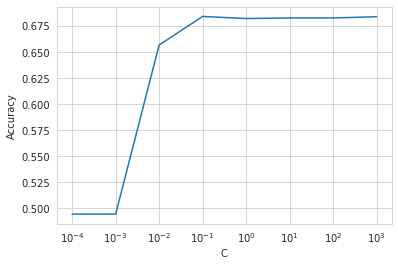

In [285]:
y = grid1.cv_results_["mean_test_score"]
x = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
sns.set_style('whitegrid')
graph = sns.lineplot(x, y)
graph.set(xscale='log')
graph.set(xlabel = "C")
graph.set(ylabel = "Accuracy")
plt.savefig('Accuracy_from_Lasso_C_1.pdf', bbox_inches='tight')

In [286]:
## Best C was 0.1, hence let's try more values of this order of magnitude:
# c = [0.01]
# add = 0.01
# while c[-1] < 1:
#     if c[-1] > 0.1:
#         add = 0.1
#     c.append(c[-1] + add)
# print(c)

param_grid = {
    'C': [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.00]
}
   
grid2 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=10), param_grid, scoring = "accuracy", verbose = 3,n_jobs=-1) 

# fitting the model for grid search 
grid2.fit(X_train_df_scaled, y_train) 
 
# print best parameter after tuning 
print(grid2.best_params_) 
grid2_predictions = grid2.predict(X_test_df_scaled) 
   
# print classification report 
print(classification_report(y_test, grid2_predictions)) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .............................C=0.1;, score=0.696 total time=   0.1s
[CV 2/5] END .............................C=0.1;, score=0.708 total time=   0.2s
[CV 3/5] END .............................C=0.1;, score=0.686 total time=   0.2s
[CV 4/5] END .............................C=0.1;, score=0.689 total time=   0.3s
[CV 5/5] END .............................C=0.1;, score=0.671 total time=   0.2s
[CV 1/5] END .............................C=0.2;, score=0.694 total time=   0.5s
[CV 2/5] END .............................C=0.2;, score=0.702 total time=   0.6s
[CV 3/5] END .............................C=0.2;, score=0.681 total time=   0.6s
[CV 4/5] END .............................C=0.2;, score=0.686 total time=   0.5s
[CV 5/5] END .............................C=0.2;, score=0.666 total time=   0.3s
[CV 1/5] END .............................C=0.3;, score=0.694 total time=   0.6s
[CV 2/5] END .............................C=0.3;

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


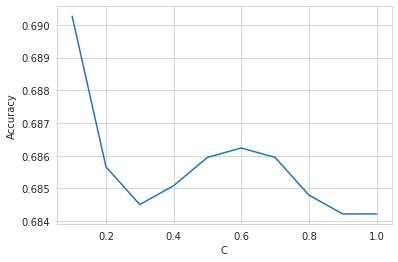

In [287]:
y = grid2.cv_results_["mean_test_score"]
x = [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.00]
sns.set_style('whitegrid')
graph = sns.lineplot(x, y)
# graph.set(xscale="logit")
graph.set(xlabel = "C")
graph.set(ylabel = "Accuracy")
graph.figure.savefig('Accuracy_from_Lasso_C_2.pdf', bbox_inches='tight')

#### Run the best C

In [84]:
sel_ = SelectFromModel(LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=10))
sel_.fit(X_train_df_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.1, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [85]:
sel_.get_support()

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
        True, False,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False,
        True, False, False,  True, False,  True,  True, False, False,
        True, False,

In [86]:
features_to_remove = X_train_df_normal.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
features_to_remove

Index(['sentence_count_without_capital_letter_at_the_beginning',
       'between_function_word_frequency', 'in_function_word_frequency',
       'some_function_word_frequency', 'about_function_word_frequency',
       'including_function_word_frequency', 'nothing_function_word_frequency',
       'inside_function_word_frequency', 'such_function_word_frequency',
       'cos_function_word_frequency', 'it_function_word_frequency',
       'what_function_word_frequency', 'where_function_word_frequency',
       'them_function_word_frequency', 'enough_function_word_frequency',
       'every_function_word_frequency', 'lots_function_word_frequency',
       'while_function_word_frequency', 'over_function_word_frequency',
       'own_function_word_frequency', 'most_function_word_frequency',
       'around_function_word_frequency', 'following_function_word_frequency',
       'as_function_word_frequency', 'for_function_word_frequency',
       'plus_function_word_frequency', 'to_function_word_frequency

In [87]:
features_to_remove = list(features_to_remove)

In [88]:
features_to_remove[0]

'sentence_count_without_capital_letter_at_the_beginning'

## 3 RUN LOOP

In [91]:
def get_final_metrics3(model, needs_scaling):
    start = time.time()
    if needs_scaling:
        predicted3 = model.predict(X_test_df_scaled)
    else:
        predicted3 = model.predict(X_test_df_normal)
    test_time = time.time() - start
    print("Confusion matrix for comments: ")
    print(confusion_matrix(y_test, predicted3, labels = ["control", "sock"]))
    tn, fp, fn, tp = confusion_matrix(y_test, predicted3, labels = ["control", "sock"]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (tn + fp)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    print(classification_report(y_test, predicted3, target_names = ["control", "socks"]))
    class_report_dict = classification_report(y_test, predicted3, target_names = ["control", "socks"], output_dict = True)
    
    return tpr, fpr, class_report_dict, test_time
    

def my_refit_criteria(cv_results_):
    return np.argmax(
        cv_results_['mean_test_precision']
        + cv_results_['mean_test_f1'])


def fill_in_results(model, tpr, fpr, class_report_dict, test_time, train_time):
    archetype3_results[model]["TPR"].append(tpr)
    archetype3_results[model]["FPR"].append(fpr)
    archetype3_results[model]["Precision"].append(class_report_dict["macro avg"]["precision"])
    archetype3_results[model]["F-measure"].append(class_report_dict["macro avg"]["f1-score"])
    archetype3_results[model]["Train_time"].append(train_time)
    archetype3_results[model]["Test_time"].append(test_time)


In [92]:
archetype3_results = {"SVM" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "RF" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "NB" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "KNN" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []},
                     "ADA" : {"TPR" : [], "FPR" : [], "Precision": [], "F-measure" : [], "Train_time" : [], "Test_time" : []}}

for data in [(X_train1, X_test1, y_train1, y_test1), (X_train2, X_test2, y_train2, y_test2), (X_train3, X_test3, y_train3, y_test3)]:

    X_train, y_train = data_sanitycheck(data[0], data[2])
    X_test, y_test = data_sanitycheck(data[1], data[3])

    X_train_df = X3[X3.user.isin(X_train)]
    X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
    X_train_df = X_train_df.sort_values("user")
    X_train_df

    # test, expects 0 printed lines
    for i in range(0, len(X_train)):
        if X_train[i] != X_train_df.iloc[i]["user"]:
            print(X_train[i])

    X_test_df = X3[X3.user.isin(X_test)]
    X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)
    X_test_df = X_test_df.sort_values("user")
    X_test_df

    # test, expects 0 printed lines
    for i in range(0, len(X_test)):
        if X_test[i] != X_test_df.iloc[i]["user"]:
            print(X_test[i])

    X_train_df_normal = X_train_df.drop(axis = 1, labels = ["user"])
    X_test_df_normal = X_test_df.drop(axis = 1, labels = ["user"])

    scaler = preprocessing.StandardScaler().fit(X_train_df_normal)
    X_train_df_scaled = scaler.transform(X_train_df_normal)
    scaler = preprocessing.StandardScaler().fit(X_test_df_normal)
    X_test_df_scaled = scaler.transform(X_test_df_normal)

    X_train_df_normal = X_train_df_normal.drop(axis = 1, labels = features_to_remove)
    X_test_df_normal = X_test_df_normal.drop(axis = 1, labels = features_to_remove)

    scaler = preprocessing.StandardScaler().fit(X_train_df_normal)
    X_train_df_scaled = scaler.transform(X_train_df_normal)

    scaler = preprocessing.StandardScaler().fit(X_test_df_normal)
    X_test_df_scaled = scaler.transform(X_test_df_normal)
    

    ### Model selection

    #### Select the best SVM

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {'C': [0.01, 0.1, 1, 10],
                  'gamma':['scale', 'auto'],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

    grid = GridSearchCV(SVC(), param_grid, cv = 3, scoring = scoring, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_scaled, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_) 

    best_SVM3 = svm.SVC(C = grid.best_params_["C"], gamma = grid.best_params_["gamma"], kernel = grid.best_params_["kernel"])
    start = time.time()
    best_SVM3.fit(X_train_df_scaled, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics3(best_SVM3, True)
    fill_in_results("SVM", tpr, fpr, class_report_dict, test_time, train_time)
    


    #### Select the best RF

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'bootstrap': [True, False],
        'max_depth': [80, 100, 120, None],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'n_estimators': [50, 100, 200, 500, 1000]
    }

    grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_normal, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_) 
    
    best_RF_3 =RandomForestClassifier(bootstrap= grid.best_params_["bootstrap"], criterion= grid.best_params_["criterion"], max_depth= grid.best_params_["max_depth"], n_estimators= grid.best_params_["n_estimators"])
    start = time.time()
    best_RF_3.fit(X_train_df_normal, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics3(best_RF_3, False)
    fill_in_results("RF", tpr, fpr, class_report_dict, test_time, train_time)
    


    #### Select the best NB

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'var_smoothing': [10 ** -10, 10 ** -9, 10 ** -8, 10 ** -7, 10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2]
    }

    grid = GridSearchCV(GaussianNB(), param_grid, scoring = scoring, cv = 5, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_normal, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_)

    best_NB_3 = GaussianNB(var_smoothing= grid.best_params_["var_smoothing"])
    start = time.time()
    best_NB_3.fit(X_train_df_normal, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics3(best_NB_3, False)
    fill_in_results("NB", tpr, fpr, class_report_dict, test_time, train_time)
    


    #### Select the best kNN

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'n_neighbors': list(range(1,30, 5)),
        'weights':['uniform', 'distance'],
        'leaf_size': list(range(1,50, 10)),
        'p':[1,2]
    }

    grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_scaled, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_) 

    best_kNN_3 = KNeighborsClassifier(leaf_size= grid.best_params_["leaf_size"], n_neighbors= grid.best_params_["n_neighbors"], p= grid.best_params_["p"], weights= grid.best_params_["weights"])
    start = time.time()
    best_kNN_3.fit(X_train_df_scaled, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time =  get_final_metrics3(best_kNN_3, True)
    fill_in_results("KNN", tpr, fpr, class_report_dict, test_time, train_time)

    #### Select the best BN



    #### Select the best ADA

    # defining parameter range
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'macro'),
               'recall': make_scorer(recall_score, average = 'macro'),
               'f1': make_scorer(f1_score, average = 'macro')}
    param_grid = {
        'n_estimators': list(range(1,100, 10)),
        'learning_rate': list(range(1,10,1)),
        'algorithm':['SAMME', 'SAMME.R']
    }

    grid = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = scoring, cv = 3, refit = my_refit_criteria, verbose = 1,n_jobs=-1) 

    # fitting the model for grid search 
    grid.fit(X_train_df_normal, y_train) 

    # print best parameter after tuning 
    print(grid.best_params_)
    
    best_ADA_3 = AdaBoostClassifier(algorithm= grid.best_params_["algorithm"], learning_rate= grid.best_params_["learning_rate"], n_estimators= grid.best_params_["n_estimators"])
    start = start = time.time()
    best_ADA_3.fit(X_train_df_normal, y_train)
    train_time = time.time() - start
    tpr, fpr, class_report_dict, test_time = get_final_metrics3(best_ADA_3, False)
    fill_in_results("ADA", tpr, fpr, class_report_dict, test_time, train_time)

/tmp/ipykernel_70/3035002132.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
/tmp/ipykernel_70/3035002132.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Pr

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Confusion matrix for comments: 
[[479 284]
 [203 524]]
TPR: 0.7207702888583218
FPR: 0.3722149410222805
              precision    recall  f1-score   support

     control       0.70      0.63      0.66       763
       socks       0.65      0.72      0.68       727

    accuracy                           0.67      1490
   macro avg       0.68      0.67      0.67      1490
weighted avg       0.68      0.67      0.67      1490

Fitting 3 folds for each of 120 candidates, totalling 360 fits
{'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 120, 'n_estimators': 1000}
Confusion matrix for comments: 
[[578 185]
 [155 572]]
TPR: 0.7867950481430537
FPR: 0.24246395806028834
              precision    recall  f1-score   support

     control       0.79      0.76      0.77       763
       socks       0.76      0.79      0.77       727

    accuracy                           0.77      1490
   macro avg       0.77      0.77      0.77      14

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/co

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 51}
Confusion matrix for comments: 
[[575 188]
 [179 548]]
TPR: 0.7537826685006878
FPR: 0.24639580602883354
              precision    recall  f1-score   support

     control       0.76      0.75      0.76       763
       socks       0.74      0.75      0.75       727

    accuracy                           0.75      1490
   macro avg       0.75      0.75      0.75      1490
weighted avg       0.75      0.75      0.75      1490



/tmp/ipykernel_70/3035002132.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
/tmp/ipykernel_70/3035002132.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Pr

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Confusion matrix for comments: 
[[499 229]
 [230 532]]
TPR: 0.6981627296587927
FPR: 0.31456043956043955
              precision    recall  f1-score   support

     control       0.68      0.69      0.68       728
       socks       0.70      0.70      0.70       762

    accuracy                           0.69      1490
   macro avg       0.69      0.69      0.69      1490
weighted avg       0.69      0.69      0.69      1490

Fitting 3 folds for each of 120 candidates, totalling 360 fits
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 1000}
Confusion matrix for comments: 
[[568 160]
 [173 589]]
TPR: 0.7729658792650919
FPR: 0.21978021978021978
              precision    recall  f1-score   support

     control       0.77      0.78      0.77       728
       socks       0.79      0.77      0.78       762

    accuracy                           0.78      1490
   macro avg       0.78      0.78      0.78      14

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

{'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 61}
Confusion matrix for comments: 
[[520 208]
 [184 578]]
TPR: 0.7585301837270341
FPR: 0.2857142857142857
              precision    recall  f1-score   support

     control       0.74      0.71      0.73       728
       socks       0.74      0.76      0.75       762

    accuracy                           0.74      1490
   macro avg       0.74      0.74      0.74      1490
weighted avg       0.74      0.74      0.74      1490



/tmp/ipykernel_70/3035002132.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_df['user'] = pd.Categorical(X_train_df['user'], X_train)
/tmp/ipykernel_70/3035002132.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['user'] = pd.Categorical(X_test_df['user'], X_test)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Pr

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Confusion matrix for comments: 
[[522 221]
 [218 529]]
TPR: 0.7081659973226239
FPR: 0.297442799461642
              precision    recall  f1-score   support

     control       0.71      0.70      0.70       743
       socks       0.71      0.71      0.71       747

    accuracy                           0.71      1490
   macro avg       0.71      0.71      0.71      1490
weighted avg       0.71      0.71      0.71      1490

Fitting 3 folds for each of 120 candidates, totalling 360 fits
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 80, 'n_estimators': 200}
Confusion matrix for comments: 
[[573 170]
 [173 574]]
TPR: 0.7684069611780455
FPR: 0.2288021534320323
              precision    recall  f1-score   support

     control       0.77      0.77      0.77       743
       socks       0.77      0.77      0.77       747

    accuracy                           0.77      1490
   macro avg       0.77      0.77      0.77      1490
weight

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 10, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reache

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 21}
Confusion matrix for comments: 
[[547 196]
 [198 549]]
TPR: 0.7349397590361446
FPR: 0.26379542395693134
              precision    recall  f1-score   support

     control       0.73      0.74      0.74       743
       socks       0.74      0.73      0.74       747

    accuracy                           0.74      1490
   macro avg       0.74      0.74      0.74      1490
weighted avg       0.74      0.74      0.74      1490



In [97]:
import pickle

with open("archetype3_results.pickle", 'wb') as f:
    pickle.dump(archetype3_results, f)

In [98]:
archetype3_results

{'SVM': {'TPR': [0.7207702888583218, 0.6981627296587927, 0.7081659973226239],
  'FPR': [0.3722149410222805, 0.31456043956043955, 0.297442799461642],
  'Precision': [0.6754304462704335, 0.6917897359080987, 0.7053693693693694],
  'F-measure': [0.6728559674492522, 0.691795128550512, 0.7053626245523189],
  'Train_time': [78.88058829307556, 8.185103416442871, 9.746365547180176],
  'Test_time': [0.25737500190734863, 0.25823044776916504, 0.2679002285003662]},
 'RF': {'TPR': [0.7867950481430537, 0.7729658792650919, 0.7684069611780455],
  'FPR': [0.24246395806028834, 0.21978021978021978, 0.2288021534320323],
  'Precision': [0.7720772562044835, 0.7764567781783719, 0.7698009455446971],
  'F-measure': [0.7718083802989464, 0.7764656643205105, 0.7697985540284464],
  'Train_time': [22.763672351837158, 25.682870388031006, 3.703249454498291],
  'Test_time': [0.3780357837677002, 0.38397741317749023, 0.08293271064758301]},
 'NB': {'TPR': [0.9243466299862448, 0.8976377952755905, 0.9089692101740294],
  'FP

In [101]:
for model, results in archetype3_results.items():
    print("--------------------------")
    print(str(model) + " RESULTS: ")
    iteration_dict = results.copy()
    for metric, res in iteration_dict.items():  
        print(metric)
        average = sum(res)/len(res)
        name = metric + " AVG"
        archetype3_results[model][name] = average
        print("M = " + str(average))
        std = np.std(res)
        name = metric + " STD"
        archetype3_results[model][name] = std
        print("STD = " + str(std))
        

--------------------------
SVM RESULTS: 
TPR
M = 0.7090330052799128
STD = 0.009249836407149976
FPR
M = 0.328072726681454
STD = 0.03198598355344197
Precision
M = 0.6908631838493005
STD = 0.012240061359302843
F-measure
M = 0.6900045735173611
STD = 0.01333104783326365
Train_time
M = 32.27068575223287
STD = 32.96434079436302
Test_time
M = 0.2611685593922933
STD = 0.004772803064661417
--------------------------
RF RESULTS: 
TPR
M = 0.7760559628620637
STD = 0.007818435394859232
FPR
M = 0.23034877709084678
STD = 0.009324949656563495
Precision
M = 0.7727783266425176
STD = 0.0027620827686350895
F-measure
M = 0.7726908662159677
STD = 0.0027924512477919554
Train_time
M = 17.38326406478882
STD = 9.746367839592047
Test_time
M = 0.2816486358642578
STD = 0.14053431358224733
--------------------------
NB RESULTS: 
TPR
M = 0.9103178784786216
STD = 0.010945460019177572
FPR
M = 0.7303454131448129
STD = 0.009559766323129307
Precision
M = 0.6529246773150172
STD = 0.006974413968305561
F-measure
M = 0.542965

In [102]:
# save results to excel:
archetype3_results_df = pd.DataFrame(data=archetype3_results)
archetype3_results_df = archetype3_results_df.T
archetype3_results_df.to_excel('text+non_text_results.xlsx')
archetype3_results_df

,TPR,FPR,Precision,F-measure,Train_time,Test_time,TPR AVG,TPR STD,FPR AVG,FPR STD,Precision AVG,Precision STD,F-measure AVG,F-measure STD,Train_time AVG,Train_time STD,Test_time AVG,Test_time STD
SVM,"[0.7207702888583218, 0.6981627296587927, 0.708...","[0.3722149410222805, 0.31456043956043955, 0.29...","[0.6754304462704335, 0.6917897359080987, 0.705...","[0.6728559674492522, 0.691795128550512, 0.7053...","[78.88058829307556, 8.185103416442871, 9.74636...","[0.25737500190734863, 0.25823044776916504, 0.2...",0.709033,0.00925,0.328073,0.031986,0.690863,0.01224,0.690005,0.013331,32.270686,32.964341,0.261169,0.004773
RF,"[0.7867950481430537, 0.7729658792650919, 0.768...","[0.24246395806028834, 0.21978021978021978, 0.2...","[0.7720772562044835, 0.7764567781783719, 0.769...","[0.7718083802989464, 0.7764656643205105, 0.769...","[22.763672351837158, 25.682870388031006, 3.703...","[0.3780357837677002, 0.38397741317749023, 0.08...",0.776056,0.007818,0.230349,0.009325,0.772778,0.002762,0.772691,0.002792,17.383264,9.746368,0.281649,0.140534
NB,"[0.9243466299862448, 0.8976377952755905, 0.908...","[0.7418086500655308, 0.7184065934065934, 0.730...","[0.6622785086032259, 0.6455379543944189, 0.650...","[0.5360734027751664, 0.5501539942300515, 0.542...","[0.012118339538574219, 0.0118865966796875, 0.0...","[0.0044896602630615234, 0.004777669906616211, ...",0.910318,0.010945,0.730345,0.00956,0.652925,0.006974,0.542965,0.005752,0.011771,0.000341,0.004766,0.000221
KNN,"[0.6657496561210454, 0.6443569553805775, 0.650...","[0.4036697247706422, 0.36675824175824173, 0.41...","[0.6314867876472461, 0.6387693383508514, 0.617...","[0.6300612051139591, 0.6387797404470079, 0.616...","[0.0033321380615234375, 0.003747701644897461, ...","[0.9587185382843018, 0.9855525493621826, 1.042...",0.65357,0.008982,0.395437,0.020882,0.629382,0.008653,0.628608,0.008958,0.003567,0.000174,0.99554,0.034864
ADA,"[0.7537826685006878, 0.7585301837270341, 0.734...","[0.24639580602883354, 0.2857142857142857, 0.26...","[0.7535823434436628, 0.7370026601896831, 0.735...","[0.7536103697849525, 0.7365135045400083, 0.735...","[1.1830840110778809, 1.436157464981079, 0.4974...","[0.03195905685424805, 0.03168511390686035, 0.0...",0.749084,0.010188,0.265302,0.016087,0.742052,0.008174,0.741898,0.008291,1.038893,0.396562,0.026409,0.007657
